In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arc import *
from time import time
from scipy.optimize import curve_fit
from typing import List, Dict

from basics import *
from utility import *
from floquet_hamiltonian import *

pi=np.pi
tau=2*pi

In [2]:
exp_pol = pd.read_csv("Pin1_4780MHz_Polarizabilities.csv")

In [6]:
exp_pol

RF power (dBm)  RF Frequency (MHz)  Effective Polarizability 0 (MHz/V^2)  \
0          -100.0                4780                                 -3.51   
1           -17.0                4780                                 -2.40   
2           -15.0                4780                                 -2.46   
3           -14.0                4780                                 -2.36   
4           -11.0                4780                                 -2.02   
5            -9.0                4780                                 -1.97   
6            -6.5                4780                                 -1.53   

   Error 0 (MHz/V^2)  Effective Polarizability 1 (MHz/V^2)  Error 1 (MHz/V^2)  \
0               0.04                                   NaN                NaN   
1               0.05                                 -2.78              0.060   
2               0.09                                 -2.76              0.140   
3               0.04                                 -2.44              0.160   
4               0.08                                 -2.07              0.150   
5               0.10                                 -1.85              0.470   
6               0.17                                 -1.00              0.272   

   Effective Polarizability 2 (MHz/V^2)  Error 2 (MHz/V^2)  \
0                                   NaN                NaN   
1                                   NaN                NaN   
2                                   NaN                NaN   
3                                   NaN                NaN   
4                                 -2.22               0.16   
5                                 -1.95               0.03   
6                                 -1.62               0.52   

   Effective Polarizability 3 (MHz/V^2)  Error 3 (MHz/V^2)  
0                                   NaN                NaN  
1                                 -2.33               0.03  
2                                 -2.26               0.19  
3                                 -2.17               0.13  
4                                 -2.32               0.15  
5                                 -2.26               0.47  
6                                 -1.96               0.35

<IPython.core.display.Javascript object>


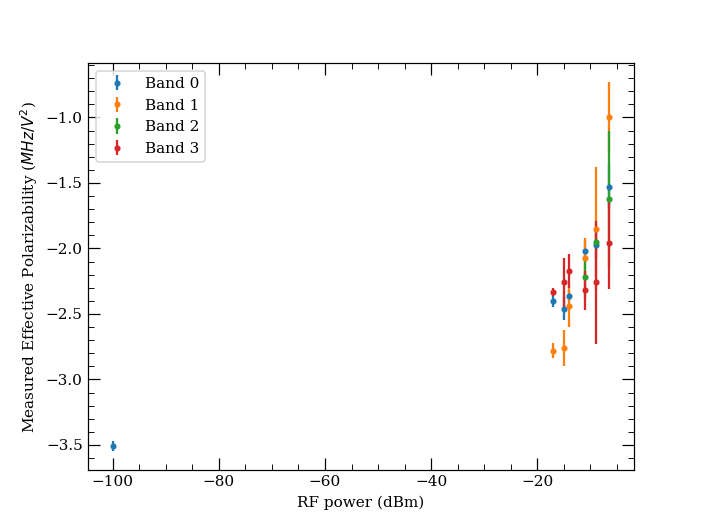

In [10]:
x_dat = exp_pol["RF power (dBm)"]
y_str = "Effective Polarizability {} (MHz/V^2)"
er_str = "Error {} (MHz/V^2)"
fig, ax = plt.subplots(1,1)
for band in range(4):
    y_dat = exp_pol[y_str.format(band)]
    y_err = exp_pol[er_str.format(band)]
    ax.errorbar(x_dat,y_dat,yerr=y_err,fmt=".",label = f"Band {band}")
ax.legend()
ax.set_xlabel("RF power (dBm)")
ax.set_ylabel("Measured Effective Polarizability ($MHz/V^2$)")
fig.show()

<IPython.core.display.Javascript object>


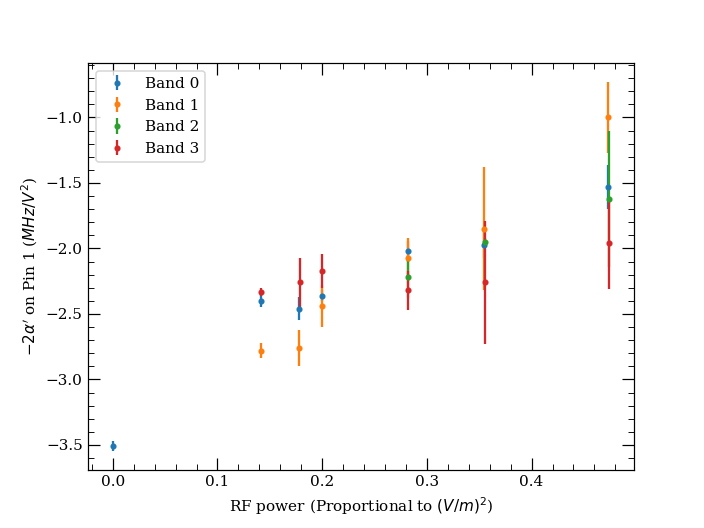

In [54]:
x_dat_dB = exp_pol["RF power (dBm)"]
x_dat_scale = np.sqrt(10**(x_dat_dB/10))
y_str = "Effective Polarizability {} (MHz/V^2)"
er_str = "Error {} (MHz/V^2)"
fig, ax = plt.subplots(1,1)
for band in range(4):
    y_dat = exp_pol[y_str.format(band)]
    y_err = exp_pol[er_str.format(band)]
    ax.errorbar(x_dat_scale+band*2e-4,y_dat,yerr=y_err,fmt=".",label = f"Band {band}")
ax.legend()
ax.set_xlabel("RF power (Proportional to $(V/m)^2$)")
ax.set_ylabel("$-2\\alpha'$ on Pin 1 ($MHz/V^2$)")
fig.show()

In [3]:
res_df = pd.read_csv("Measured_RF_Resonances_4780.csv")
res_df

RF power (dBm)  RF Frequency (MHz)  mu 1 (MHz)  sig 1 (MHz)  mu 2 (MHz)  \
0           -100.0                 NaN       40.50         0.00         NaN   
1            -17.0              4780.0      -12.30         0.14       -17.8   
2            -16.5              4780.0      -17.20         0.34       -23.4   
3            -16.0              4780.0      -22.80         0.26       -29.5   
4            -15.0              4780.0      -34.60         0.16       -43.3   
5            -14.0              4780.0      -50.20         0.28       -60.0   
6            -13.0              4780.0      -65.90         0.26       -76.2   
7            -12.0              4780.0      -85.40         0.19       -96.2   
8            -11.0              4780.0     -107.53         0.10      -118.4   
9             -9.0              4780.0     -162.50         0.20      -174.4   
10            -6.5              4780.0     -252.90         0.20      -265.8   

    sig 2 (MHz)  mu 3 (MHz)  sig 3 (MHz)  mu 4 (MHz)  sig 4 (MHz)  mu 5 (MHz)  \
0           NaN         NaN          NaN         NaN          NaN         NaN   
1          1.40       -24.9         1.90         NaN          NaN         NaN   
2          0.67       -30.7         0.85         NaN          NaN         NaN   
3          0.46       -36.3        -0.59         NaN          NaN         NaN   
4          0.35       -49.8         0.47         NaN          NaN         NaN   
5          0.48       -67.0         0.60         NaN          NaN         NaN   
6          0.69       -84.4         0.95      -108.0         1.40         NaN   
7          0.66      -108.0         0.91         NaN          NaN         NaN   
8          0.33      -126.0         0.51      -134.5         0.63         NaN   
9          0.38      -185.3         0.52      -200.4         0.66         NaN   
10         0.40      -279.4         0.55      -288.1         0.74      -306.3   

    sig 5 (MHz)  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
5           NaN  
6           NaN  
7           NaN  
8           NaN  
9           NaN  
10         0.91

<IPython.core.display.Javascript object>


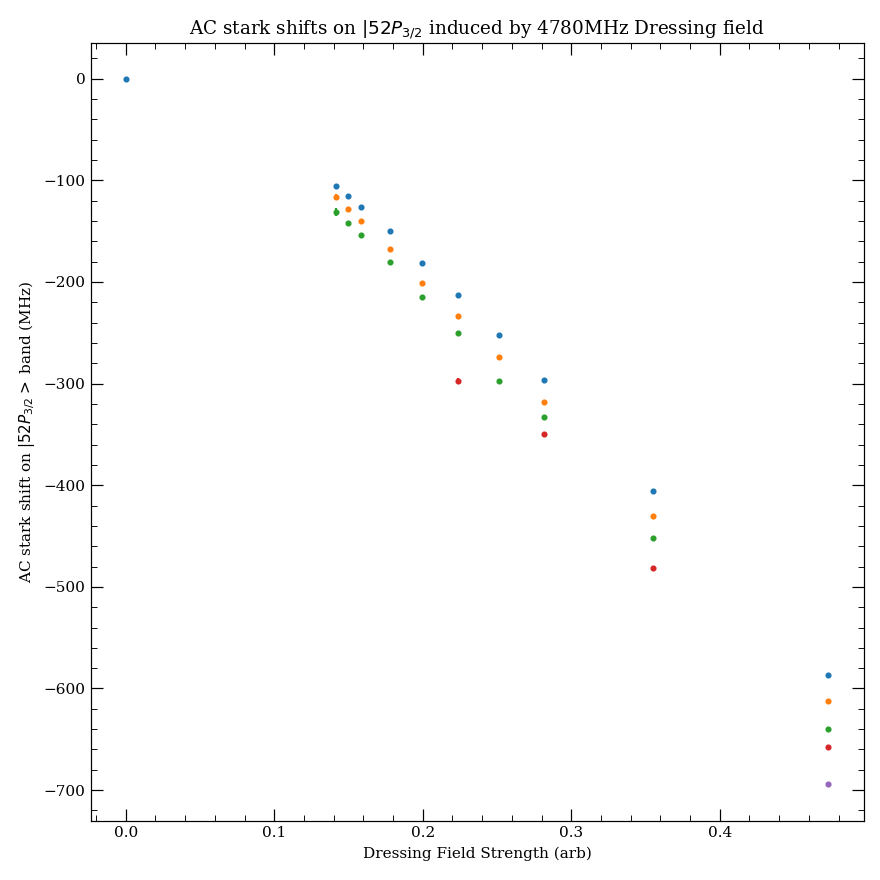

In [4]:
bands = range(1,6)
x_data_dBm = res_df["RF power (dBm)"]
x_data_Vs = np.sqrt(10**(x_data_dBm/10))
y_str = "mu {} (MHz)"
er_str = "sig {} (MHz)"
bare_res = res_df["mu 1 (MHz)"][0]
fig, ax = plt.subplots(1,1, figsize=(8,8))
for band in bands:
    measured_res = res_df[y_str.format(band)]
    errb = res_df[er_str.format(band)]
    dAC = 2*(measured_res-bare_res)
    dAC_er = 2*errb
    ax.errorbar(x_data_Vs, dAC, yerr = dAC_er, fmt = ".")
ax.set_title("AC stark shifts on $|52P_{3/2}$ induced by 4780MHz Dressing field")
ax.set_xlabel("Dressing Field Strength (arb)")
ax.set_ylabel("AC stark shift on $|52P_{3/2}>$ band (MHz)")
fig.tight_layout()
fig.show()
fig.savefig("Unscaled Wiki AC stark shifts.png")

In [18]:
fields = {
#    "Eac": np.append(np.linspace(0,22,200), np.linspace(22+22/200,100,200)),
    "Eac": 80,
    "ellipticity": np.linspace(0,np.sqrt(0.04),200)**2,
    "field_omega": tau*4780e6,
    "Edc": 0.0,
    "theta": 0
}

for key, value in fields.items():
    try:
        tmp = value[1]
    except TypeError:
        continue
    else:
        varied = (key, value)

t_level = RydStateFS(52,1,3/2)
max_det = tau*30e9
dl = 1
n_max = 3

comp = {"n_max": n_max, "dl": dl, "max_det": max_det}

levels, basis = build_basis(t_level, max_det, single_side=False, dl=dl)
basis_n = build_n_basis(basis, n_max)

In [19]:
H0 = build_H0(basis, t_level, offset_zeeman=1e6)
energies, eigenstates = floquet_loop(basis, H0, n_max=n_max, varied=varied, **fields)

140
Levels :

[
	|52,S,1/2>,
	|52,P,1/2>,
	|52,P,3/2>,
	|51,D,3/2>,
	|51,D,5/2>,
	|53,S,1/2>
]
little_d built in 0.0029871463775634766
Hdc built in 0.0
dipoles_ac built in 0.06579065322875977
Hfloquet put together in 0.0
Floquet matrix built after 0.06877779960632324 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 80, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.044164180755615234s
Normalization Complete after 0.0020287036895751953 s
floquet_diag call completed in 0.11497068405151367s
Diagonalization complete for independent variable entry, value 0, 0.0
finding good eigenvectors for |level, n> = ||52,S,1/2>,-3>
finding good eigenvectors for |level, n> = ||52,S,1/2>,-2>
finding good eigenvectors for |level, n> = ||52,S,1/2>,-1>
finding good eigenvectors for |level, n> = ||52,S,1/2>,0>
finding good eigenvectors for |level, n> = ||52,S,1/2>,1>
finding good eigenvectors for |level, n> = ||52,

C:\Users\Juan\Repos\two_photon_rydberg\floquet_hamiltonian.py:533: ComplexWarning: Casting complex values to real discards the imaginary part
  energies[inds[:, 1], i] = eigenvalues[inds[:, 0]]


dipoles_ac built in 0.07088613510131836
Hfloquet put together in 0.0009970664978027344
Floquet matrix built after 0.07528042793273926 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 80, ellipticity 9.090679528294742e-06, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0448460578918457s
Normalization Complete after 0.002027273178100586 s
floquet_diag call completed in 0.12215375900268555s
Diagonalization complete for independent variable entry, value 3, 9.090679528294742e-06
re-arrangement done after time 0.002958536148071289s
little_d built in 0.003025054931640625
Hdc built in 0.0
dipoles_ac built in 0.06479406356811523
Hfloquet put together in 0.0
Floquet matrix built after 0.06781911849975586 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 80, ellipticity 1.6161208050301762e-05, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04

dipoles_ac built in 0.0658266544342041
Hfloquet put together in 0.0009517669677734375
Floquet matrix built after 0.06977367401123047 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 80, ellipticity 0.00029191182040857555, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04233121871948242s
Normalization Complete after 0.0020279884338378906 s
floquet_diag call completed in 0.11413288116455078s
Diagonalization complete for independent variable entry, value 17, 0.00029191182040857555
re-arrangement done after time 0.002991199493408203s
little_d built in 0.002993345260620117
Hdc built in 0.0
dipoles_ac built in 0.0648338794708252
Hfloquet put together in 0.0009975433349609375
Floquet matrix built after 0.06882476806640625 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 80, ellipticity 0.0003272644630186107, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonali

dipoles_ac built in 0.06582474708557129
Hfloquet put together in 0.0009970664978027344
Floquet matrix built after 0.06984353065490723 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 80, ellipticity 0.0009706825585212497, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04292035102844238s
Normalization Complete after 0.0019943714141845703 s
floquet_diag call completed in 0.11475825309753418s
Diagonalization complete for independent variable entry, value 31, 0.0009706825585212497
re-arrangement done after time 0.002960681915283203s
little_d built in 0.003988742828369141
Hdc built in 0.0
dipoles_ac built in 0.06485843658447266
Hfloquet put together in 0.0009970664978027344
Floquet matrix built after 0.06984424591064453 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 80, ellipticity 0.0010343173152193128, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonali

dipoles_ac built in 0.06682133674621582
Hfloquet put together in 0.0010421276092529297
Floquet matrix built after 0.07082557678222656 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 80, ellipticity 0.0020454028938663165, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04353737831115723s
Normalization Complete after 0.002035856246948242 s
floquet_diag call completed in 0.11639881134033203s
Diagonalization complete for independent variable entry, value 45, 0.0020454028938663165
re-arrangement done after time 0.0029506683349609375s
little_d built in 0.0040318965911865234
Hdc built in 0.0
dipoles_ac built in 0.06382036209106445
Hfloquet put together in 0.0
Floquet matrix built after 0.06884765625 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 80, ellipticity 0.0021373197646524086, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04366

dipoles_ac built in 0.06486630439758301
Hfloquet put together in 0.0
Floquet matrix built after 0.06885075569152832 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 80, ellipticity 0.0035160728264437774, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04374122619628906s
Normalization Complete after 0.0030341148376464844 s
floquet_diag call completed in 0.11562609672546387s
Diagonalization complete for independent variable entry, value 59, 0.0035160728264437774
re-arrangement done after time 0.001995086669921875s
little_d built in 0.002991914749145508
Hdc built in 0.0
dipoles_ac built in 0.06578302383422852
Hfloquet put together in 0.0
Floquet matrix built after 0.06877493858337402 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 80, ellipticity 0.0036362718113178965, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04408693313598633s

dipoles_ac built in 0.06582403182983398
Hfloquet put together in 0.0
Floquet matrix built after 0.06881594657897949 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 80, ellipticity 0.005382692356253631, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04392719268798828s
Normalization Complete after 0.002027273178100586 s
floquet_diag call completed in 0.11477041244506836s
Diagonalization complete for independent variable entry, value 73, 0.005382692356253631
re-arrangement done after time 0.0029947757720947266s
little_d built in 0.002991199493408203
Hdc built in 0.0009958744049072266
dipoles_ac built in 0.06482768058776855
Hfloquet put together in 0.0
Floquet matrix built after 0.06982231140136719 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 80, ellipticity 0.005531173455215779, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.042

dipoles_ac built in 0.06586527824401855
Hfloquet put together in 0.0009548664093017578
Floquet matrix built after 0.07077646255493164 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 80, ellipticity 0.007645261483295878, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04349493980407715s
Normalization Complete after 0.002028942108154297 s
floquet_diag call completed in 0.11630034446716309s
Diagonalization complete for independent variable entry, value 87, 0.007645261483295878
re-arrangement done after time 0.0029904842376708984s
little_d built in 0.002992391586303711
Hdc built in 0.0
dipoles_ac built in 0.06583142280578613
Hfloquet put together in 0.0
Floquet matrix built after 0.06882381439208984 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 80, ellipticity 0.007822024696346052, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.044

dipoles_ac built in 0.06687402725219727
Hfloquet put together in 0.0009434223175048828
Floquet matrix built after 0.07081174850463867 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 80, ellipticity 0.010303780207570517, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04340839385986328s
Normalization Complete after 0.002027750015258789 s
floquet_diag call completed in 0.11624789237976074s
Diagonalization complete for independent variable entry, value 101, 0.010303780207570517
re-arrangement done after time 0.002992391586303711s
little_d built in 0.002992391586303711
Hdc built in 0.0
dipoles_ac built in 0.06482553482055664
Hfloquet put together in 0.0
Floquet matrix built after 0.06781792640686035 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 80, ellipticity 0.010508825534708723, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.044

dipoles_ac built in 0.06583285331726074
Hfloquet put together in 0.000989675521850586
Floquet matrix built after 0.07081294059753418 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 80, ellipticity 0.013358248529077552, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04349803924560547s
Normalization Complete after 0.0019974708557128906 s
floquet_diag call completed in 0.11630845069885254s
Diagonalization complete for independent variable entry, value 115, 0.013358248529077552
re-arrangement done after time 0.0029892921447753906s
little_d built in 0.0029914379119873047
Hdc built in 0.0
dipoles_ac built in 0.0717768669128418
Hfloquet put together in 0.0
Floquet matrix built after 0.07576489448547363 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 80, ellipticity 0.013591575970303783, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04

Normalization Complete after 0.0009582042694091797 s
floquet_diag call completed in 0.12005996704101562s
Diagonalization complete for independent variable entry, value 127, 0.01629150779020732
re-arrangement done after time 0.002991199493408203s
little_d built in 0.0030241012573242188
Hdc built in 0.0
dipoles_ac built in 0.06582427024841309
Hfloquet put together in 0.0009996891021728516
Floquet matrix built after 0.06984806060791016 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 80, ellipticity 0.016549077043509004, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.044898033142089844s
Normalization Complete after 0.0020287036895751953 s
floquet_diag call completed in 0.11773872375488281s
Diagonalization complete for independent variable entry, value 128, 0.016549077043509004
re-arrangement done after time 0.0020360946655273438s
little_d built in 0.004944562911987305
Hdc built in 0.0
dipoles_ac built in 0.0658

dipoles_ac built in 0.06683182716369629
Hfloquet put together in 0.0
Floquet matrix built after 0.07082080841064453 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 80, ellipticity 0.019797479861619664, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04600024223327637s
Normalization Complete after 0.001992464065551758 s
floquet_diag call completed in 0.11881351470947266s
Diagonalization complete for independent variable entry, value 140, 0.019797479861619664
re-arrangement done after time 0.0030362606048583984s
little_d built in 0.0039768218994140625
Hdc built in 0.0
dipoles_ac built in 0.06583642959594727
Hfloquet put together in 0.000993490219116211
Floquet matrix built after 0.07080674171447754 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 80, ellipticity 0.020081311078003088, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04

dipoles_ac built in 0.06683063507080078
Hfloquet put together in 0.0
Floquet matrix built after 0.06982302665710449 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 80, ellipticity 0.023644857453094623, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04341745376586914s
Normalization Complete after 0.0020270347595214844 s
floquet_diag call completed in 0.11526751518249512s
Diagonalization complete for independent variable entry, value 153, 0.023644857453094623
re-arrangement done after time 0.0019948482513427734s
little_d built in 0.002991199493408203
Hdc built in 0.000995635986328125
dipoles_ac built in 0.06483721733093262
Hfloquet put together in 0.0
Floquet matrix built after 0.06982707977294922 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 80, ellipticity 0.02395495063255979, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.051

Hfloquet put together in 0.0009641647338867188
Floquet matrix built after 0.06981325149536133 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 80, ellipticity 0.027833640564632212, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04488015174865723s
Normalization Complete after 0.0019941329956054688 s
floquet_diag call completed in 0.11768484115600586s
Diagonalization complete for independent variable entry, value 166, 0.027833640564632212
re-arrangement done after time 0.002285480499267578s
little_d built in 0.0029914379119873047
Hdc built in 0.0
dipoles_ac built in 0.06690597534179688
Hfloquet put together in 0.0
Floquet matrix built after 0.07089495658874512 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 80, ellipticity 0.02816999570717912, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04576253890991211s
Normalization Complete 

dipoles_ac built in 0.06579780578613281
Hfloquet put together in 0.0009951591491699219
Floquet matrix built after 0.07081079483032227 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 80, ellipticity 0.03236382919623242, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04448103904724121s
Normalization Complete after 0.00196075439453125 s
floquet_diag call completed in 0.11725258827209473s
Diagonalization complete for independent variable entry, value 179, 0.03236382919623242
re-arrangement done after time 0.001995563507080078s
little_d built in 0.004024028778076172
Hdc built in 0.0
dipoles_ac built in 0.06579017639160156
Hfloquet put together in 0.0010311603546142578
Floquet matrix built after 0.07084536552429199 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 80, ellipticity 0.03272644630186106, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized aft

dipoles_ac built in 0.06778407096862793
Hfloquet put together in 0.0009987354278564453
Floquet matrix built after 0.07277297973632812 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 80, ellipticity 0.037235423347895265, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0439302921295166s
Normalization Complete after 0.001962423324584961 s
floquet_diag call completed in 0.11866569519042969s
Diagonalization complete for independent variable entry, value 192, 0.037235423347895265
re-arrangement done after time 0.0029916763305664062s
little_d built in 0.0030329227447509766
Hdc built in 0.0
dipoles_ac built in 0.06578278541564941
Hfloquet put together in 0.0009982585906982422
Floquet matrix built after 0.06981396675109863 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 80, ellipticity 0.03762430241660565, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized

<IPython.core.display.Javascript object>


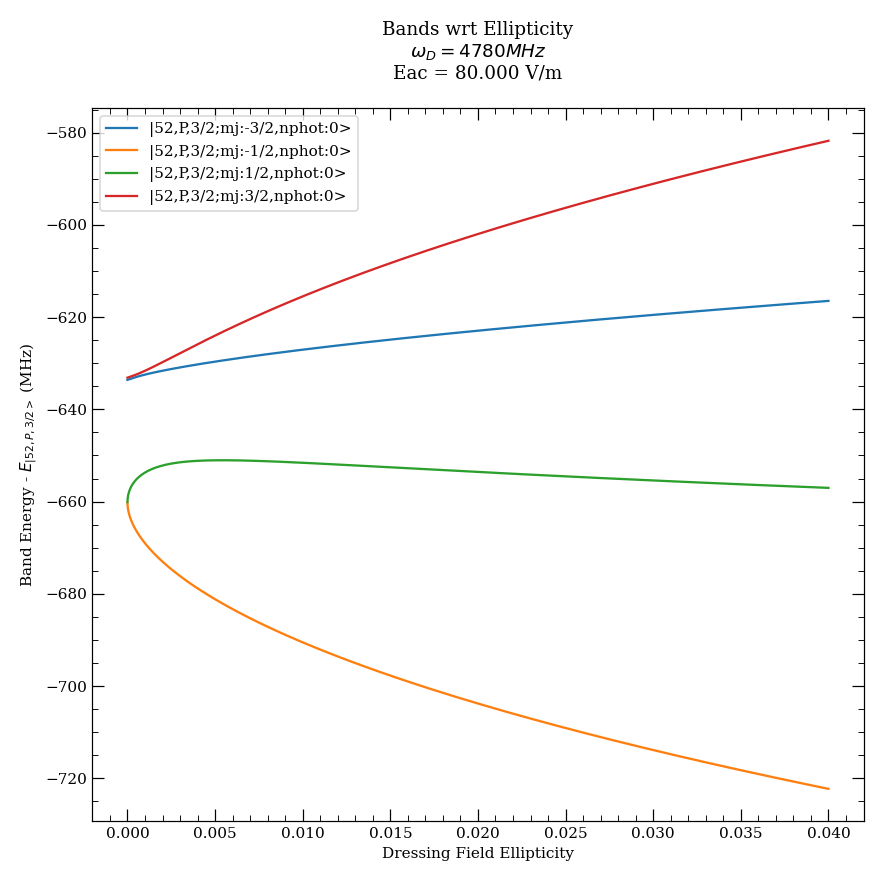

In [27]:
thrs = 0.5
fig, ax = plt.subplots(1,1, figsize=(8,8))

basis_t = [i+len(basis)*n_max for i, state in enumerate(basis) if [state.n, state.l, state.j] == [t_level.n, t_level.l, t_level.j]]
interesting_inds = []
for t_ind in basis_t:
    for k, ps in enumerate(eigenstates[:, t_ind, :]):
        if max(np.absolute(ps)**2) > thrs:
            interesting_inds.append(k)

interesting_inds = list(set(interesting_inds))
for k in interesting_inds:
    ax.plot(varied[1], 1e-6*np.real(energies[k,:]-energies[k,0]*0)/tau,label = basis_n[k].ket())

scale = 79/0.474
for band in bands:
    measured_res = res_df[y_str.format(band)]
    errb = res_df[er_str.format(band)]
    dAC = 2*(measured_res-bare_res)
    dAC_er = 2*errb
    x_data_scaled = x_data_Vs*scale
#    ax.errorbar(x_data_scaled, dAC, yerr = dAC_er, fmt = ".", label=f"band {band}")

#ax.set_title(f"AC stark shifts\n$\omega_D = {fields['field_omega']*1e-6/tau:.0f} MHz$\n$\epsilon = {fields['ellipticity']:.3f}$")
#ax.set_ylabel("AC stark shift (MHz)")
#ax.set_xlabel("AC field strength (V/m)")
ax.set_title(f"Bands wrt Ellipticity\n$\omega_D = {fields['field_omega']*1e-6/tau:.0f} MHz$\nEac = {fields['Eac']:.3f} V/m\n")
ax.set_ylabel(f"Band Energy - $E_{{{t_level.ket()}}}$ (MHz)")
ax.set_xlabel("Dressing Field Ellipticity")
ax.legend()
fig.tight_layout()
fig.show()
#fig.savefig(f"Theory-Experiment_handscale_ellipticity_{fields['ellipticity']:.3f}.png")#
fig.savefig(f"Band Frequency ellipticity.png")

140
Levels :

[
	|52,S,1/2>,
	|52,P,1/2>,
	|52,P,3/2>,
	|51,D,3/2>,
	|51,D,5/2>,
	|53,S,1/2>
]
little_d built in 0.002991199493408203
Hdc built in 0.0
Hfloquet put together in 0.0009953975677490234
Floquet matrix built after 0.0039865970611572266 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 0.0, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.002959728240966797s
Normalization Complete after 0.002027273178100586 s
floquet_diag call completed in 0.00897359848022461s
Diagonalization complete for independent variable entry, value 0, 0.0
finding good eigenvectors for |level, n> = ||52,S,1/2>,-3>
finding good eigenvectors for |level, n> = ||52,S,1/2>,-2>
finding good eigenvectors for |level, n> = ||52,S,1/2>,-1>
finding good eigenvectors for |level, n> = ||52,S,1/2>,0>
finding good eigenvectors for |level, n> = ||52,S,1/2>,1>
finding good eigenvectors for |level, n> = ||52,S,1/2>,2>
finding goo

DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.041595458984375s
Normalization Complete after 0.0019958019256591797 s
floquet_diag call completed in 0.04658317565917969s
Diagonalization complete for independent variable entry, value 11, 1.2160804020100504
re-arrangement done after time 0.0029904842376708984s
little_d built in 0.003988981246948242
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003988981246948242 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 1.3266331658291457, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04239940643310547s
Normalization Complete after 0.00203704833984375 s
floquet_diag call completed in 0.04842543601989746s
Diagonalization complete for independent variable entry, value 12, 1.3266331658291457
re-arrangement done after time 0.00299072265625s
little_d built in 0.0029976367950439453
Hdc built in 0.0
Hfloquet put together

Normalization Complete after 0.002027750015258789 s
floquet_diag call completed in 0.047448158264160156s
Diagonalization complete for independent variable entry, value 27, 2.984924623115578
re-arrangement done after time 0.0029947757720947266s
little_d built in 0.0029897689819335938
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003985166549682617 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 3.0954773869346734, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.042107343673706055s
Normalization Complete after 0.002027273178100586 s
floquet_diag call completed in 0.04811978340148926s
Diagonalization complete for independent variable entry, value 28, 3.0954773869346734
re-arrangement done after time 0.0029938220977783203s
little_d built in 0.00299072265625
Hdc built in 0.0
Hfloquet put together in 0.0009975433349609375
Floquet matrix built after 0.003988265991210937

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 4.7537688442211055, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04379153251647949s
Normalization Complete after 0.0019958019256591797 s
floquet_diag call completed in 0.04976630210876465s
Diagonalization complete for independent variable entry, value 43, 4.7537688442211055
re-arrangement done after time 0.003023862838745117s
little_d built in 0.0029938220977783203
Hdc built in 0.0
Hfloquet put together in 0.0009629726409912109
Floquet matrix built after 0.003956794738769531 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 4.864321608040202, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.042978525161743164s
Normalization Complete after 0.0020270347595214844 s
floquet_diag call completed in 0.04896235466003418s
Diagonalization complete for independent variable entry, va

Normalization Complete after 0.0020456314086914062 s
floquet_diag call completed in 0.04888558387756348s
Diagonalization complete for independent variable entry, value 59, 6.522613065326634
re-arrangement done after time 0.0029408931732177734s
little_d built in 0.0029921531677246094
Hdc built in 0.0009975433349609375
Hfloquet put together in 0.0
Floquet matrix built after 0.003989696502685547 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 6.633165829145729, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04291033744812012s
Normalization Complete after 0.002030611038208008 s
floquet_diag call completed in 0.04893064498901367s
Diagonalization complete for independent variable entry, value 60, 6.633165829145729
re-arrangement done after time 0.0029892921447753906s
little_d built in 0.003988981246948242
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.00398898124694824

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 8.291457286432161, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04280972480773926s
Normalization Complete after 0.0020341873168945312 s
floquet_diag call completed in 0.04982471466064453s
Diagonalization complete for independent variable entry, value 75, 8.291457286432161
re-arrangement done after time 0.002961397171020508s
little_d built in 0.0030219554901123047
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.004021406173706055 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 8.402010050251256, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04338216781616211s
Normalization Complete after 0.001996755599975586 s
floquet_diag call completed in 0.04940032958984375s
Diagonalization complete for independent variable entry, value 76, 8.402010050251

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 10.06030150753769, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04416847229003906s
Normalization Complete after 0.002027750015258789 s
floquet_diag call completed in 0.051186323165893555s
Diagonalization complete for independent variable entry, value 91, 10.06030150753769
re-arrangement done after time 0.002002239227294922s
little_d built in 0.003000497817993164
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003000497817993164 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 10.170854271356784, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04421567916870117s
Normalization Complete after 0.00196075439453125 s
floquet_diag call completed in 0.049176931381225586s
Diagonalization complete for independent variable entry, value 92, 10.17085427135

Normalization Complete after 0.001978635787963867 s
floquet_diag call completed in 0.047910213470458984s
Diagonalization complete for independent variable entry, value 107, 11.829145728643217
re-arrangement done after time 0.001995086669921875s
little_d built in 0.003027200698852539
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003027200698852539 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 11.939698492462313, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04304862022399902s
Normalization Complete after 0.0019521713256835938 s
floquet_diag call completed in 0.048027992248535156s
Diagonalization complete for independent variable entry, value 108, 11.939698492462313
re-arrangement done after time 0.0029926300048828125s
little_d built in 0.004040956497192383
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.004040956497192383 s
Begin Dia

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 13.597989949748744, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04336071014404297s
Normalization Complete after 0.0019931793212890625 s
floquet_diag call completed in 0.04936361312866211s
Diagonalization complete for independent variable entry, value 123, 13.597989949748744
re-arrangement done after time 0.00299072265625s
little_d built in 0.0030243396759033203
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.00402379035949707 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 13.70854271356784, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04426288604736328s
Normalization Complete after 0.0020287036895751953 s
floquet_diag call completed in 0.05031538009643555s
Diagonalization complete for independent variable entry, value 124, 13.70854271356

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 15.366834170854272, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04343676567077637s
Normalization Complete after 0.0020263195037841797 s
floquet_diag call completed in 0.04945540428161621s
Diagonalization complete for independent variable entry, value 139, 15.366834170854272
re-arrangement done after time 0.002981901168823242s
little_d built in 0.003999948501586914
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003999948501586914 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 15.477386934673367, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04420161247253418s
Normalization Complete after 0.002027273178100586 s
floquet_diag call completed in 0.05022883415222168s
Diagonalization complete for independent variable entry, value 140, 15.4773869

Normalization Complete after 0.0020263195037841797 s
floquet_diag call completed in 0.04935312271118164s
Diagonalization complete for independent variable entry, value 155, 17.1356783919598
re-arrangement done after time 0.0029587745666503906s
little_d built in 0.003023386001586914
Hdc built in 0.0009975433349609375
Hfloquet put together in 0.0
Floquet matrix built after 0.0040209293365478516 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 17.246231155778897, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04201817512512207s
Normalization Complete after 0.001995563507080078 s
floquet_diag call completed in 0.04803466796875s
Diagonalization complete for independent variable entry, value 156, 17.246231155778897
re-arrangement done after time 0.0029914379119873047s
little_d built in 0.0029916763305664062
Hdc built in 0.0009992122650146484
Hfloquet put together in 0.0
Floquet matrix built after 

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 18.90452261306533, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04225468635559082s
Normalization Complete after 0.001997232437133789 s
floquet_diag call completed in 0.04827165603637695s
Diagonalization complete for independent variable entry, value 171, 18.90452261306533
re-arrangement done after time 0.002989530563354492s
little_d built in 0.002991914749145508
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.002991914749145508 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 19.015075376884422, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04329657554626465s
Normalization Complete after 0.0020270347595214844 s
floquet_diag call completed in 0.0493161678314209s
Diagonalization complete for independent variable entry, value 172, 19.0150753768

Normalization Complete after 0.001961946487426758 s
floquet_diag call completed in 0.049065351486206055s
Diagonalization complete for independent variable entry, value 187, 20.673366834170857
re-arrangement done after time 0.002992391586303711s
little_d built in 0.003988742828369141
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003988742828369141 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 20.78391959798995, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04573678970336914s
Normalization Complete after 0.002028942108154297 s
floquet_diag call completed in 0.05175447463989258s
Diagonalization complete for independent variable entry, value 188, 20.78391959798995
re-arrangement done after time 0.002990245819091797s
little_d built in 0.002991199493408203
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0039882659912109375 s
Begin Diagona

Normalization Complete after 0.002027273178100586 s
floquet_diag call completed in 0.04907488822937012s
Diagonalization complete for independent variable entry, value 203, 23.28422110552764
re-arrangement done after time 0.001961946487426758s
little_d built in 0.0030241012573242188
Hdc built in 0.00101470947265625
Hfloquet put together in 0.0
Floquet matrix built after 0.004038810729980469 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 23.675628140703516, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0429682731628418s
Normalization Complete after 0.002026081085205078 s
floquet_diag call completed in 0.050031185150146484s
Diagonalization complete for independent variable entry, value 204, 23.675628140703516
re-arrangement done after time 0.002002716064453125s
little_d built in 0.0029916763305664062
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.00299167633056640

Normalization Complete after 0.0020265579223632812 s
floquet_diag call completed in 0.049401283264160156s
Diagonalization complete for independent variable entry, value 219, 29.54673366834171
re-arrangement done after time 0.0029587745666503906s
little_d built in 0.0029916763305664062
Hdc built in 0.0
Hfloquet put together in 0.0009975433349609375
Floquet matrix built after 0.003989219665527344 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 29.938140703517586, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0421905517578125s
Normalization Complete after 0.0019941329956054688 s
floquet_diag call completed in 0.04817390441894531s
Diagonalization complete for independent variable entry, value 220, 29.938140703517586
re-arrangement done after time 0.0029914379119873047s
little_d built in 0.002994060516357422
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.002994060516

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 35.809246231155775, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.042902469635009766s
Normalization Complete after 0.0019953250885009766 s
floquet_diag call completed in 0.04888629913330078s
Diagonalization complete for independent variable entry, value 235, 35.809246231155775
re-arrangement done after time 0.0029909610748291016s
little_d built in 0.0029914379119873047
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0029914379119873047 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 36.200653266331656, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04430270195007324s
Normalization Complete after 0.0019941329956054688 s
floquet_diag call completed in 0.049288272857666016s
Diagonalization complete for independent variable entry, value 236, 36.2

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 42.07175879396985, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.045009613037109375s
Normalization Complete after 0.002027750015258789 s
floquet_diag call completed in 0.05002927780151367s
Diagonalization complete for independent variable entry, value 251, 42.07175879396985
re-arrangement done after time 0.00299072265625s
little_d built in 0.0029942989349365234
Hdc built in 0.0010063648223876953
Hfloquet put together in 0.0
Floquet matrix built after 0.004000663757324219 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 42.46316582914572, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.044327735900878906s
Normalization Complete after 0.001993894577026367 s
floquet_diag call completed in 0.05032229423522949s
Diagonalization complete for independent variable entry, value 25

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 48.334271356783916, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04293084144592285s
Normalization Complete after 0.0029904842376708984 s
floquet_diag call completed in 0.04991269111633301s
Diagonalization complete for independent variable entry, value 267, 48.334271356783916
re-arrangement done after time 0.002027750015258789s
little_d built in 0.002991914749145508
Hdc built in 0.0009639263153076172
Hfloquet put together in 0.0
Floquet matrix built after 0.003955841064453125 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 48.725678391959796, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04392361640930176s
Normalization Complete after 0.0020318031311035156 s
floquet_diag call completed in 0.0499112606048584s
Diagonalization complete for independent variable entry, val

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 54.59678391959799, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.043849945068359375s
Normalization Complete after 0.001993894577026367 s
floquet_diag call completed in 0.04883313179016113s
Diagonalization complete for independent variable entry, value 283, 54.59678391959799
re-arrangement done after time 0.003036975860595703s
little_d built in 0.0029938220977783203
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0029938220977783203 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 54.98819095477387, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04474139213562012s
Normalization Complete after 0.0009975433349609375 s
floquet_diag call completed in 0.04972648620605469s
Diagonalization complete for independent variable entry, value 284, 54.9881909

Normalization Complete after 0.002029895782470703 s
floquet_diag call completed in 0.04927396774291992s
Diagonalization complete for independent variable entry, value 299, 60.859296482412056
re-arrangement done after time 0.003954648971557617s
little_d built in 0.0029926300048828125
Hdc built in 0.0
Hfloquet put together in 0.0010333061218261719
Floquet matrix built after 0.004025936126708984 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 61.25070351758794, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04225969314575195s
Normalization Complete after 0.0020074844360351562 s
floquet_diag call completed in 0.048293113708496094s
Diagonalization complete for independent variable entry, value 300, 61.25070351758794
re-arrangement done after time 0.002978801727294922s
little_d built in 0.002992391586303711
Hdc built in 0.0010001659393310547
Hfloquet put together in 0.0
Floquet matrix built after

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 67.12180904522613, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.044317007064819336s
Normalization Complete after 0.0019941329956054688 s
floquet_diag call completed in 0.04930257797241211s
Diagonalization complete for independent variable entry, value 315, 67.12180904522613
re-arrangement done after time 0.002993345260620117s
little_d built in 0.0030329227447509766
Hdc built in 0.0009982585906982422
Hfloquet put together in 0.0
Floquet matrix built after 0.004031181335449219 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 67.513216080402, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.044371843338012695s
Normalization Complete after 0.0010306835174560547 s
floquet_diag call completed in 0.05043339729309082s
Diagonalization complete for independent variable entry, valu

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 73.3843216080402, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04335379600524902s
Normalization Complete after 0.002026796340942383 s
floquet_diag call completed in 0.04937148094177246s
Diagonalization complete for independent variable entry, value 331, 73.3843216080402
re-arrangement done after time 0.002991199493408203s
little_d built in 0.003992557525634766
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003992557525634766 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 73.77572864321607, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.044112205505371094s
Normalization Complete after 0.001996755599975586 s
floquet_diag call completed in 0.050101518630981445s
Diagonalization complete for independent variable entry, value 332, 73.77572864321

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 79.64683417085428, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04347062110900879s
Normalization Complete after 0.001995086669921875 s
floquet_diag call completed in 0.04945826530456543s
Diagonalization complete for independent variable entry, value 347, 79.64683417085428
re-arrangement done after time 0.003023386001586914s
little_d built in 0.0030012130737304688
Hdc built in 0.0010001659393310547
Hfloquet put together in 0.0
Floquet matrix built after 0.0040013790130615234 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 80.03824120603015, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04432797431945801s
Normalization Complete after 0.0020270347595214844 s
floquet_diag call completed in 0.050356388092041016s
Diagonalization complete for independent variable entry, val

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 85.90934673366834, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04516863822937012s
Normalization Complete after 0.0019948482513427734 s
floquet_diag call completed in 0.051184892654418945s
Diagonalization complete for independent variable entry, value 363, 85.90934673366834
re-arrangement done after time 0.003032684326171875s
little_d built in 0.002994060516357422
Hdc built in 0.0009946823120117188
Hfloquet put together in 0.0
Floquet matrix built after 0.003988742828369141 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 86.30075376884422, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.044744253158569336s
Normalization Complete after 0.001994609832763672 s
floquet_diag call completed in 0.05072760581970215s
Diagonalization complete for independent variable entry, valu

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 92.17185929648241, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04456138610839844s
Normalization Complete after 0.0020301342010498047 s
floquet_diag call completed in 0.04958486557006836s
Diagonalization complete for independent variable entry, value 379, 92.17185929648241
re-arrangement done after time 0.002991199493408203s
little_d built in 0.0029931068420410156
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003954410552978516 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 92.56326633165828, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04417157173156738s
Normalization Complete after 0.002027273178100586 s
floquet_diag call completed in 0.050153255462646484s
Diagonalization complete for independent variable entry, value 380, 92.56326633

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 98.43437185929648, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04329705238342285s
Normalization Complete after 0.002946138381958008 s
floquet_diag call completed in 0.049234628677368164s
Diagonalization complete for independent variable entry, value 395, 98.43437185929648
re-arrangement done after time 0.003042936325073242s
little_d built in 0.0029735565185546875
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003971576690673828 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 98.82577889447236, ellipticity 0.0, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04332232475280762s
Normalization Complete after 0.0020291805267333984 s
floquet_diag call completed in 0.049323081970214844s
Diagonalization complete for independent variable entry, value 396, 98.8257788

<IPython.core.display.Javascript object>


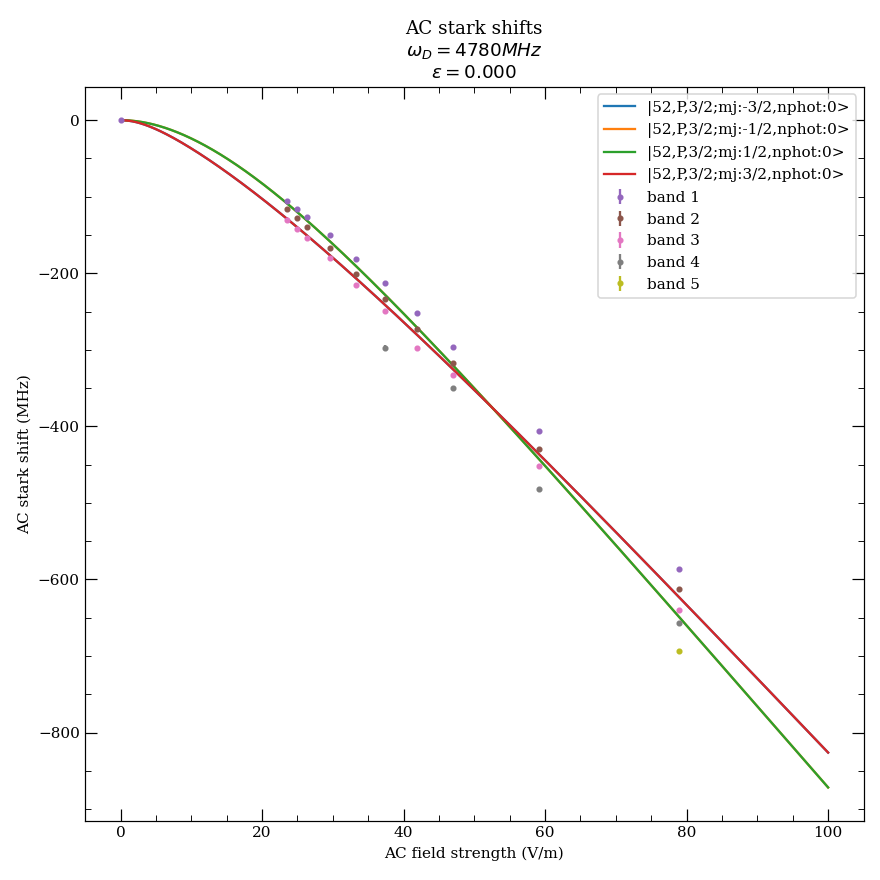

140
Levels :

[
	|52,S,1/2>,
	|52,P,1/2>,
	|52,P,3/2>,
	|51,D,3/2>,
	|51,D,5/2>,
	|53,S,1/2>
]
little_d built in 0.003989219665527344
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003989219665527344 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 0.0, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0029921531677246094s
Normalization Complete after 0.001995086669921875 s
floquet_diag call completed in 0.008976459503173828s
Diagonalization complete for independent variable entry, value 0, 0.0
finding good eigenvectors for |level, n> = ||52,S,1/2>,-3>
finding good eigenvectors for |level, n> = ||52,S,1/2>,-2>
finding good eigenvectors for |level, n> = ||52,S,1/2>,-1>
finding good eigenvectors for |level, n> = ||52,S,1/2>,0>
finding good eigenvectors for |level, n> = ||52,S,1/2>,1>
finding good eigenvectors for |level, n> = ||52,S,1/2>,2>
finding good eigenvectors 

C:\Users\Juan\Repos\two_photon_rydberg\floquet_hamiltonian.py:533: ComplexWarning: Casting complex values to real discards the imaginary part
  energies[inds[:, 1], i] = eigenvalues[inds[:, 0]]


Hfloquet put together in 0.0009989738464355469
Floquet matrix built after 0.0039904117584228516 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 0.44221105527638194, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.043881893157958984s
Normalization Complete after 0.0019941329956054688 s
floquet_diag call completed in 0.049866437911987305s
Diagonalization complete for independent variable entry, value 4, 0.44221105527638194
re-arrangement done after time 0.002992391586303711s
little_d built in 0.0029914379119873047
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003988742828369141 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 0.5527638190954774, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04165482521057129s
Normalization Complete after 0.0030252933502197266 s
floq

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 2.100502512562814, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04219484329223633s
Normalization Complete after 0.001995086669921875 s
floquet_diag call completed in 0.04817938804626465s
Diagonalization complete for independent variable entry, value 19, 2.100502512562814
re-arrangement done after time 0.0029914379119873047s
little_d built in 0.0030241012573242188
Hdc built in 0.0009663105010986328
Hfloquet put together in 0.0
Floquet matrix built after 0.0039904117584228516 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 2.21105527638191, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04265403747558594s
Normalization Complete after 0.0019953250885009766 s
floquet_diag call completed in 0.048639774322509766s
Diagonalization complete for independent variable entry, 

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 3.869346733668342, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04288339614868164s
Normalization Complete after 0.001997232437133789 s
floquet_diag call completed in 0.04887199401855469s
Diagonalization complete for independent variable entry, value 35, 3.869346733668342
re-arrangement done after time 0.002989053726196289s
little_d built in 0.003027677536010742
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0039904117584228516 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 3.9798994974874375, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04289412498474121s
Normalization Complete after 0.001992940902709961 s
floquet_diag call completed in 0.04887747764587402s
Diagonalization complete for independent variable entry, value 36, 3.97989949

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 5.63819095477387, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.042645931243896484s
Normalization Complete after 0.001995563507080078 s
floquet_diag call completed in 0.048629045486450195s
Diagonalization complete for independent variable entry, value 51, 5.63819095477387
re-arrangement done after time 0.0029921531677246094s
little_d built in 0.004028797149658203
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.004028797149658203 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 5.748743718592965, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04250836372375488s
Normalization Complete after 0.0019989013671875 s
floquet_diag call completed in 0.048536062240600586s
Diagonalization complete for independent variable entry, value 52, 5.7487437185

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 7.407035175879398, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.042894601821899414s
Normalization Complete after 0.0020270347595214844 s
floquet_diag call completed in 0.049910545349121094s
Diagonalization complete for independent variable entry, value 67, 7.407035175879398
re-arrangement done after time 0.0030007362365722656s
little_d built in 0.0029914379119873047
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0029914379119873047 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 7.517587939698493, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04332756996154785s
Normalization Complete after 0.0020294189453125 s
floquet_diag call completed in 0.048348426818847656s
Diagonalization complete for independent variable entry, value 68, 7.51758

Normalization Complete after 0.002979278564453125 s
floquet_diag call completed in 0.050215959548950195s
Diagonalization complete for independent variable entry, value 83, 9.175879396984925
re-arrangement done after time 0.002988100051879883s
little_d built in 0.0030236244201660156
Hdc built in 0.0
Hfloquet put together in 0.0009653568267822266
Floquet matrix built after 0.003988981246948242 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 9.28643216080402, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04225945472717285s
Normalization Complete after 0.0019919872283935547 s
floquet_diag call completed in 0.04824042320251465s
Diagonalization complete for independent variable entry, value 84, 9.28643216080402
re-arrangement done after time 0.0019943714141845703s
little_d built in 0.002991914749145508
Hdc built in 0.0010042190551757812
Hfloquet put together in 0.0
Floquet matrix built after 0

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 10.944723618090453, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04239058494567871s
Normalization Complete after 0.0019948482513427734 s
floquet_diag call completed in 0.048374176025390625s
Diagonalization complete for independent variable entry, value 99, 10.944723618090453
re-arrangement done after time 0.0029916763305664062s
little_d built in 0.003026247024536133
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003990888595581055 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 11.055276381909549, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04474449157714844s
Normalization Complete after 0.0009975433349609375 s
floquet_diag call completed in 0.050730228424072266s
Diagonalization complete for independent variable entry, value 100, 11.

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 12.713567839195981, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.042176008224487305s
Normalization Complete after 0.000988006591796875 s
floquet_diag call completed in 0.048154592514038086s
Diagonalization complete for independent variable entry, value 115, 12.713567839195981
re-arrangement done after time 0.0029556751251220703s
little_d built in 0.0030176639556884766
Hdc built in 0.0
Hfloquet put together in 0.0009958744049072266
Floquet matrix built after 0.004013538360595703 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 12.824120603015077, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04228687286376953s
Normalization Complete after 0.0019826889038085938 s
floquet_diag call completed in 0.04828310012817383s
Diagonalization complete for independent variable en

Normalization Complete after 0.0019910335540771484 s
floquet_diag call completed in 0.04956364631652832s
Diagonalization complete for independent variable entry, value 131, 14.482412060301508
re-arrangement done after time 0.0019953250885009766s
little_d built in 0.003024578094482422
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003024578094482422 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 14.592964824120603, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0423731803894043s
Normalization Complete after 0.0019943714141845703 s
floquet_diag call completed in 0.04739212989807129s
Diagonalization complete for independent variable entry, value 132, 14.592964824120603
re-arrangement done after time 0.001995563507080078s
little_d built in 0.003988981246948242
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003988981246948242 s
Begin Dia

Normalization Complete after 0.001995563507080078 s
floquet_diag call completed in 0.047821760177612305s
Diagonalization complete for independent variable entry, value 147, 16.251256281407038
re-arrangement done after time 0.0030341148376464844s
little_d built in 0.002991199493408203
Hdc built in 0.0009553432464599609
Hfloquet put together in 0.0
Floquet matrix built after 0.003946542739868164 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 16.36180904522613, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0419611930847168s
Normalization Complete after 0.002034425735473633 s
floquet_diag call completed in 0.047942161560058594s
Diagonalization complete for independent variable entry, value 148, 16.36180904522613
re-arrangement done after time 0.0029840469360351562s
little_d built in 0.0029938220977783203
Hdc built in 0.0
Hfloquet put together in 0.0009641647338867188
Floquet matrix built af

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 18.020100502512562, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04337430000305176s
Normalization Complete after 0.0020263195037841797 s
floquet_diag call completed in 0.04842495918273926s
Diagonalization complete for independent variable entry, value 163, 18.020100502512562
re-arrangement done after time 0.002991914749145508s
little_d built in 0.002995014190673828
Hdc built in 0.0
Hfloquet put together in 0.0009944438934326172
Floquet matrix built after 0.003989458084106445 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 18.13065326633166, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04244089126586914s
Normalization Complete after 0.002003908157348633 s
floquet_diag call completed in 0.04843425750732422s
Diagonalization complete for independent variable entry, 

Normalization Complete after 0.0020155906677246094 s
floquet_diag call completed in 0.0476226806640625s
Diagonalization complete for independent variable entry, value 179, 19.78894472361809
re-arrangement done after time 0.0029914379119873047s
little_d built in 0.0029916763305664062
Hdc built in 0.0
Hfloquet put together in 0.0010020732879638672
Floquet matrix built after 0.0039937496185302734 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 19.899497487437188, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04260706901550293s
Normalization Complete after 0.0019457340240478516 s
floquet_diag call completed in 0.048546552658081055s
Diagonalization complete for independent variable entry, value 180, 19.899497487437188
re-arrangement done after time 0.0030319690704345703s
little_d built in 0.0029921531677246094
Hdc built in 0.0
Hfloquet put together in 0.000957489013671875
Floquet matrix built

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 21.55778894472362, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0434267520904541s
Normalization Complete after 0.001993894577026367 s
floquet_diag call completed in 0.049410104751586914s
Diagonalization complete for independent variable entry, value 195, 21.55778894472362
re-arrangement done after time 0.00311279296875s
little_d built in 0.003023862838745117
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.004021644592285156 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 21.668341708542716, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.042556047439575195s
Normalization Complete after 0.0019958019256591797 s
floquet_diag call completed in 0.04857349395751953s
Diagonalization complete for independent variable entry, value 196, 21.66834170

Diagonalized after time: 0.041707754135131836s
Normalization Complete after 0.002028942108154297 s
floquet_diag call completed in 0.04772329330444336s
Diagonalization complete for independent variable entry, value 211, 26.415477386934672
re-arrangement done after time 0.0029947757720947266s
little_d built in 0.0029900074005126953
Hdc built in 0.0009951591491699219
Hfloquet put together in 0.0
Floquet matrix built after 0.003985166549682617 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 26.806884422110553, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0426480770111084s
Normalization Complete after 0.002026796340942383 s
floquet_diag call completed in 0.0486600399017334s
Diagonalization complete for independent variable entry, value 212, 26.806884422110553
re-arrangement done after time 0.0029954910278320312s
little_d built in 0.002956867218017578
Hdc built in 0.0
Hfloquet put together in

Normalization Complete after 0.0020296573638916016 s
floquet_diag call completed in 0.049150705337524414s
Diagonalization complete for independent variable entry, value 227, 32.67798994974874
re-arrangement done after time 0.0029897689819335938s
little_d built in 0.0029599666595458984
Hdc built in 0.0010287761688232422
Hfloquet put together in 0.0
Floquet matrix built after 0.003988742828369141 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 33.06939698492462, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0419459342956543s
Normalization Complete after 0.0020279884338378906 s
floquet_diag call completed in 0.04796266555786133s
Diagonalization complete for independent variable entry, value 228, 33.06939698492462
re-arrangement done after time 0.0029904842376708984s
little_d built in 0.0029926300048828125
Hdc built in 0.0
Hfloquet put together in 0.0009970664978027344
Floquet matrix built a

Normalization Complete after 0.0019614696502685547 s
floquet_diag call completed in 0.05043506622314453s
Diagonalization complete for independent variable entry, value 243, 38.940502512562816
re-arrangement done after time 0.0030252933502197266s
little_d built in 0.00299072265625
Hdc built in 0.0
Hfloquet put together in 0.00099945068359375
Floquet matrix built after 0.00399017333984375 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 39.33190954773869, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.042850494384765625s
Normalization Complete after 0.0010318756103515625 s
floquet_diag call completed in 0.04886794090270996s
Diagonalization complete for independent variable entry, value 244, 39.33190954773869
re-arrangement done after time 0.0019958019256591797s
little_d built in 0.0029909610748291016
Hdc built in 0.000997781753540039
Hfloquet put together in 0.0
Floquet matrix built after 0.

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 45.20301507537688, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0437929630279541s
Normalization Complete after 0.002036571502685547 s
floquet_diag call completed in 0.04882192611694336s
Diagonalization complete for independent variable entry, value 259, 45.20301507537688
re-arrangement done after time 0.0029916763305664062s
little_d built in 0.0029916763305664062
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0029916763305664062 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 45.59442211055276, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04313397407531738s
Normalization Complete after 0.0019974708557128906 s
floquet_diag call completed in 0.0491180419921875s
Diagonalization complete for independent variable entry, value 260, 45.59442

Normalization Complete after 0.0019943714141845703 s
floquet_diag call completed in 0.051308393478393555s
Diagonalization complete for independent variable entry, value 275, 51.46552763819095
re-arrangement done after time 0.0029587745666503906s
little_d built in 0.0030243396759033203
Hdc built in 0.0
Hfloquet put together in 0.0009655952453613281
Floquet matrix built after 0.0039899349212646484 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 51.85693467336684, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04288506507873535s
Normalization Complete after 0.0020291805267333984 s
floquet_diag call completed in 0.0489041805267334s
Diagonalization complete for independent variable entry, value 276, 51.85693467336684
re-arrangement done after time 0.002992391586303711s
little_d built in 0.0029914379119873047
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.00299143791

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 57.72804020100502, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04376721382141113s
Normalization Complete after 0.0020284652709960938 s
floquet_diag call completed in 0.04978346824645996s
Diagonalization complete for independent variable entry, value 291, 57.72804020100502
re-arrangement done after time 0.003000974655151367s
little_d built in 0.002991199493408203
Hdc built in 0.0
Hfloquet put together in 0.0009992122650146484
Floquet matrix built after 0.0039904117584228516 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 58.1194472361809, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.048340559005737305s
Normalization Complete after 0.0019943714141845703 s
floquet_diag call completed in 0.05432534217834473s
Diagonalization complete for independent variable entry, 

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 63.990552763819096, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04377269744873047s
Normalization Complete after 0.0020034313201904297 s
floquet_diag call completed in 0.04979753494262695s
Diagonalization complete for independent variable entry, value 307, 63.990552763819096
re-arrangement done after time 0.0029506683349609375s
little_d built in 0.004030942916870117
Hdc built in 0.0
Hfloquet put together in 0.0009970664978027344
Floquet matrix built after 0.0050280094146728516 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 64.38195979899497, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04342389106750488s
Normalization Complete after 0.0019915103912353516 s
floquet_diag call completed in 0.05144071578979492s
Diagonalization complete for independent variable entr

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 70.25306532663316, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.043691396713256836s
Normalization Complete after 0.0020313262939453125 s
floquet_diag call completed in 0.049714088439941406s
Diagonalization complete for independent variable entry, value 323, 70.25306532663316
re-arrangement done after time 0.002989530563354492s
little_d built in 0.0029916763305664062
Hdc built in 0.0
Hfloquet put together in 0.0009984970092773438
Floquet matrix built after 0.00399017333984375 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 70.64447236180905, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04363203048706055s
Normalization Complete after 0.0010008811950683594 s
floquet_diag call completed in 0.04961824417114258s
Diagonalization complete for independent variable entry,

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 76.51557788944723, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04474925994873047s
Normalization Complete after 0.0019958019256591797 s
floquet_diag call completed in 0.04973626136779785s
Diagonalization complete for independent variable entry, value 339, 76.51557788944723
re-arrangement done after time 0.002993345260620117s
little_d built in 0.0029888153076171875
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0029888153076171875 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 76.90698492462312, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.044115304946899414s
Normalization Complete after 0.001962900161743164 s
floquet_diag call completed in 0.049067020416259766s
Diagonalization complete for independent variable entry, value 340, 76.90

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 82.7780904522613, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0438079833984375s
Normalization Complete after 0.0020020008087158203 s
floquet_diag call completed in 0.04979395866394043s
Diagonalization complete for independent variable entry, value 355, 82.7780904522613
re-arrangement done after time 0.001997709274291992s
little_d built in 0.0029897689819335938
Hdc built in 0.0
Hfloquet put together in 0.0009965896606445312
Floquet matrix built after 0.003986358642578125 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 83.16949748743718, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0430600643157959s
Normalization Complete after 0.0020284652709960938 s
floquet_diag call completed in 0.04907488822937012s
Diagonalization complete for independent variable entry, valu

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 89.04060301507538, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04414772987365723s
Normalization Complete after 0.0019936561584472656 s
floquet_diag call completed in 0.04913520812988281s
Diagonalization complete for independent variable entry, value 371, 89.04060301507538
re-arrangement done after time 0.002992868423461914s
little_d built in 0.002992391586303711
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0040318965911865234 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 89.43201005025125, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04299163818359375s
Normalization Complete after 0.0019981861114501953 s
floquet_diag call completed in 0.05001688003540039s
Diagonalization complete for independent variable entry, value 372, 89.4320

Normalization Complete after 0.0019979476928710938 s
floquet_diag call completed in 0.04973435401916504s
Diagonalization complete for independent variable entry, value 387, 95.30311557788944
re-arrangement done after time 0.002953767776489258s
little_d built in 0.0030269622802734375
Hdc built in 0.0
Hfloquet put together in 0.0009946823120117188
Floquet matrix built after 0.004021644592285156 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 95.69452261306532, ellipticity 0.005, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04385066032409668s
Normalization Complete after 0.0020270347595214844 s
floquet_diag call completed in 0.04989933967590332s
Diagonalization complete for independent variable entry, value 388, 95.69452261306532
re-arrangement done after time 0.001993417739868164s
little_d built in 0.0030035972595214844
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0039973258972

<IPython.core.display.Javascript object>


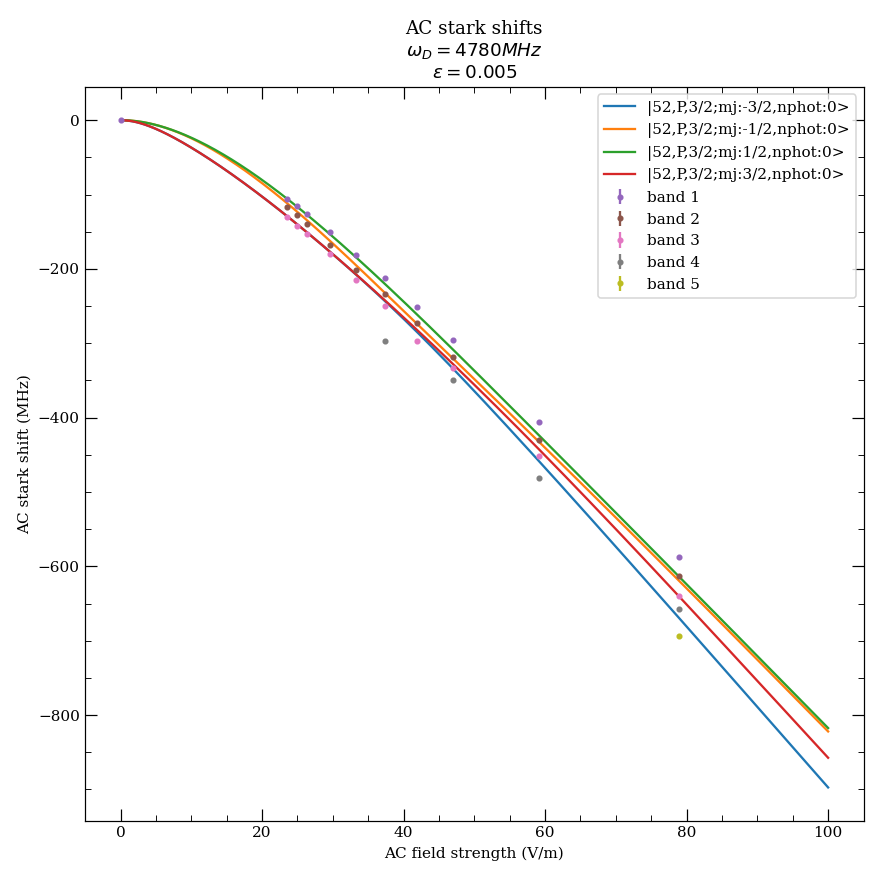

140
Levels :

[
	|52,S,1/2>,
	|52,P,1/2>,
	|52,P,3/2>,
	|51,D,3/2>,
	|51,D,5/2>,
	|53,S,1/2>
]
little_d built in 0.003988981246948242
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003988981246948242 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 0.0, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.002992868423461914s
Normalization Complete after 0.002027750015258789 s
floquet_diag call completed in 0.009009599685668945s
Diagonalization complete for independent variable entry, value 0, 0.0
finding good eigenvectors for |level, n> = ||52,S,1/2>,-3>
finding good eigenvectors for |level, n> = ||52,S,1/2>,-2>
finding good eigenvectors for |level, n> = ||52,S,1/2>,-1>
finding good eigenvectors for |level, n> = ||52,S,1/2>,0>
finding good eigenvectors for |level, n> = ||52,S,1/2>,1>
finding good eigenvectors for |level, n> = ||52,S,1/2>,2>
finding good eigenvectors fo

C:\Users\Juan\Repos\two_photon_rydberg\floquet_hamiltonian.py:533: ComplexWarning: Casting complex values to real discards the imaginary part
  energies[inds[:, 1], i] = eigenvalues[inds[:, 0]]


Hdc built in 0.0
Hfloquet put together in 0.0009944438934326172
Floquet matrix built after 0.003988981246948242 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 0.44221105527638194, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04285311698913574s
Normalization Complete after 0.0020303726196289062 s
floquet_diag call completed in 0.04887247085571289s
Diagonalization complete for independent variable entry, value 4, 0.44221105527638194
re-arrangement done after time 0.0027070045471191406s
little_d built in 0.0030236244201660156
Hdc built in 0.0
Hfloquet put together in 0.0010221004486083984
Floquet matrix built after 0.004045724868774414 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 0.5527638190954774, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04168891906738281s
Normalization Complete aft

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 2.100502512562814, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04179191589355469s
Normalization Complete after 0.0029938220977783203 s
floquet_diag call completed in 0.04874229431152344s
Diagonalization complete for independent variable entry, value 19, 2.100502512562814
re-arrangement done after time 0.00299072265625s
little_d built in 0.002991199493408203
Hdc built in 0.0
Hfloquet put together in 0.0009982585906982422
Floquet matrix built after 0.003989458084106445 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 2.21105527638191, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04205775260925293s
Normalization Complete after 0.0020296573638916016 s
floquet_diag call completed in 0.0490720272064209s
Diagonalization complete for independent variable entry, value 20, 

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 3.869346733668342, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04500579833984375s
Normalization Complete after 0.0019931793212890625 s
floquet_diag call completed in 0.050997018814086914s
Diagonalization complete for independent variable entry, value 35, 3.869346733668342
re-arrangement done after time 0.001995086669921875s
little_d built in 0.003024578094482422
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003024578094482422 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 3.9798994974874375, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0429835319519043s
Normalization Complete after 0.001992464065551758 s
floquet_diag call completed in 0.04800057411193848s
Diagonalization complete for independent variable entry, value 36, 3.9798994974

Normalization Complete after 0.001986265182495117 s
floquet_diag call completed in 0.04755592346191406s
Diagonalization complete for independent variable entry, value 51, 5.63819095477387
re-arrangement done after time 0.002958536148071289s
little_d built in 0.0029914379119873047
Hdc built in 0.000997781753540039
Hfloquet put together in 0.0
Floquet matrix built after 0.003989219665527344 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 5.748743718592965, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0424501895904541s
Normalization Complete after 0.001981019973754883 s
floquet_diag call completed in 0.04842042922973633s
Diagonalization complete for independent variable entry, value 52, 5.748743718592965
re-arrangement done after time 0.002991199493408203s
little_d built in 0.0029916763305664062
Hdc built in 0.0
Hfloquet put together in 0.0009636878967285156
Floquet matrix built after 0.003

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 7.407035175879398, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04629397392272949s
Normalization Complete after 0.0020034313201904297 s
floquet_diag call completed in 0.05224490165710449s
Diagonalization complete for independent variable entry, value 67, 7.407035175879398
re-arrangement done after time 0.0029821395874023438s
little_d built in 0.0029921531677246094
Hdc built in 0.0
Hfloquet put together in 0.0009629726409912109
Floquet matrix built after 0.00395512580871582 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 7.517587939698493, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0441434383392334s
Normalization Complete after 0.001962423324584961 s
floquet_diag call completed in 0.05006098747253418s
Diagonalization complete for independent variable entry, value

Normalization Complete after 0.00203704833984375 s
floquet_diag call completed in 0.0495905876159668s
Diagonalization complete for independent variable entry, value 83, 9.175879396984925
re-arrangement done after time 0.0029516220092773438s
little_d built in 0.003988742828369141
Hdc built in 0.0
Hfloquet put together in 0.0009975433349609375
Floquet matrix built after 0.004986286163330078 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 9.28643216080402, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.042493581771850586s
Normalization Complete after 0.002027273178100586 s
floquet_diag call completed in 0.04950714111328125s
Diagonalization complete for independent variable entry, value 84, 9.28643216080402
re-arrangement done after time 0.0020363330841064453s
little_d built in 0.003948211669921875
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.004944801330566406 s


Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 10.944723618090453, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.044130563735961914s
Normalization Complete after 0.0019953250885009766 s
floquet_diag call completed in 0.050075531005859375s
Diagonalization complete for independent variable entry, value 99, 10.944723618090453
re-arrangement done after time 0.0029921531677246094s
little_d built in 0.003034353256225586
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003989458084106445 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 11.055276381909549, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04223322868347168s
Normalization Complete after 0.0019834041595458984 s
floquet_diag call completed in 0.04921245574951172s
Diagonalization complete for independent variable entry, value 100, 11.05

Normalization Complete after 0.001994609832763672 s
floquet_diag call completed in 0.047501564025878906s
Diagonalization complete for independent variable entry, value 115, 12.713567839195981
re-arrangement done after time 0.002961874008178711s
little_d built in 0.002993345260620117
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.004021167755126953 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 12.824120603015077, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.042066335678100586s
Normalization Complete after 0.002027273178100586 s
floquet_diag call completed in 0.048114776611328125s
Diagonalization complete for independent variable entry, value 116, 12.824120603015077
re-arrangement done after time 0.002991199493408203s
little_d built in 0.002994537353515625
Hdc built in 0.0009958744049072266
Hfloquet put together in 0.0
Floquet matrix built after 0.003990411758

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 14.482412060301508, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04217529296875s
Normalization Complete after 0.002027273178100586 s
floquet_diag call completed in 0.04819130897521973s
Diagonalization complete for independent variable entry, value 131, 14.482412060301508
re-arrangement done after time 0.0029942989349365234s
little_d built in 0.0029571056365966797
Hdc built in 0.0
Hfloquet put together in 0.00102996826171875
Floquet matrix built after 0.00398707389831543 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 14.592964824120603, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04300689697265625s
Normalization Complete after 0.0009975433349609375 s
floquet_diag call completed in 0.04898953437805176s
Diagonalization complete for independent variable entry, value

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 16.251256281407038, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.042119503021240234s
Normalization Complete after 0.0019941329956054688 s
floquet_diag call completed in 0.04810357093811035s
Diagonalization complete for independent variable entry, value 147, 16.251256281407038
re-arrangement done after time 0.003950357437133789s
little_d built in 0.00398707389831543
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.00398707389831543 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 16.36180904522613, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04337620735168457s
Normalization Complete after 0.0019898414611816406 s
floquet_diag call completed in 0.05035281181335449s
Diagonalization complete for independent variable entry, value 148, 16.361809

Normalization Complete after 0.0009961128234863281 s
floquet_diag call completed in 0.04828071594238281s
Diagonalization complete for independent variable entry, value 163, 18.020100502512562
re-arrangement done after time 0.0019457340240478516s
little_d built in 0.003024578094482422
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003989696502685547 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 18.13065326633166, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04399824142456055s
Normalization Complete after 0.001995086669921875 s
floquet_diag call completed in 0.04998302459716797s
Diagonalization complete for independent variable entry, value 164, 18.13065326633166
re-arrangement done after time 0.001994609832763672s
little_d built in 0.0029931068420410156
Hdc built in 0.0
Hfloquet put together in 0.0009984970092773438
Floquet matrix built after 0.00399160385131

Normalization Complete after 0.001992464065551758 s
floquet_diag call completed in 0.04838967323303223s
Diagonalization complete for independent variable entry, value 179, 19.78894472361809
re-arrangement done after time 0.0029947757720947266s
little_d built in 0.00299072265625
Hdc built in 0.0010273456573486328
Hfloquet put together in 0.0
Floquet matrix built after 0.004018068313598633 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 19.899497487437188, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04285550117492676s
Normalization Complete after 0.002002239227294922 s
floquet_diag call completed in 0.04887580871582031s
Diagonalization complete for independent variable entry, value 180, 19.899497487437188
re-arrangement done after time 0.002991914749145508s
little_d built in 0.0029916763305664062
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003989219665527344

Normalization Complete after 0.0019991397857666016 s
floquet_diag call completed in 0.048529863357543945s
Diagonalization complete for independent variable entry, value 195, 21.55778894472362
re-arrangement done after time 0.0029582977294921875s
little_d built in 0.002991914749145508
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003989696502685547 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 21.668341708542716, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04265856742858887s
Normalization Complete after 0.0019974708557128906 s
floquet_diag call completed in 0.048645734786987305s
Diagonalization complete for independent variable entry, value 196, 21.668341708542716
re-arrangement done after time 0.0029888153076171875s
little_d built in 0.0030236244201660156
Hdc built in 0.0009672641754150391
Hfloquet put together in 0.0
Floquet matrix built after 0.003990888

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 26.415477386934672, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04321789741516113s
Normalization Complete after 0.0019943714141845703 s
floquet_diag call completed in 0.04916024208068848s
Diagonalization complete for independent variable entry, value 211, 26.415477386934672
re-arrangement done after time 0.0029997825622558594s
little_d built in 0.0029916763305664062
Hdc built in 0.0
Hfloquet put together in 0.000997304916381836
Floquet matrix built after 0.003988981246948242 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 26.806884422110553, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04330277442932129s
Normalization Complete after 0.0019953250885009766 s
floquet_diag call completed in 0.04928708076477051s
Diagonalization complete for independent variable entry,

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 32.67798994974874, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04361701011657715s
Normalization Complete after 0.001997709274291992 s
floquet_diag call completed in 0.049599409103393555s
Diagonalization complete for independent variable entry, value 227, 32.67798994974874
re-arrangement done after time 0.00299072265625s
little_d built in 0.0029571056365966797
Hdc built in 0.0
Hfloquet put together in 0.0010311603546142578
Floquet matrix built after 0.0039882659912109375 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 33.06939698492462, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.042641639709472656s
Normalization Complete after 0.003029346466064453 s
floquet_diag call completed in 0.04965925216674805s
Diagonalization complete for independent variable entry, value

DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.043410539627075195s
Normalization Complete after 0.0020275115966796875 s
floquet_diag call completed in 0.04842996597290039s
Diagonalization complete for independent variable entry, value 243, 38.940502512562816
re-arrangement done after time 0.0029942989349365234s
little_d built in 0.002992391586303711
Hdc built in 0.0
Hfloquet put together in 0.0009946823120117188
Floquet matrix built after 0.00398707389831543 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 39.33190954773869, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04285383224487305s
Normalization Complete after 0.002025604248046875 s
floquet_diag call completed in 0.04886651039123535s
Diagonalization complete for independent variable entry, value 244, 39.33190954773869
re-arrangement done after time 0.002961397171020508s
little_d built in 0.003025531768798828
Hdc built in 

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 45.20301507537688, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04184842109680176s
Normalization Complete after 0.002028226852416992 s
floquet_diag call completed in 0.04886031150817871s
Diagonalization complete for independent variable entry, value 259, 45.20301507537688
re-arrangement done after time 0.0019969940185546875s
little_d built in 0.002960681915283203
Hdc built in 0.0
Hfloquet put together in 0.0010309219360351562
Floquet matrix built after 0.003991603851318359 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 45.59442211055276, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.043485403060913086s
Normalization Complete after 0.001993894577026367 s
floquet_diag call completed in 0.04947090148925781s
Diagonalization complete for independent variable entry, val

Normalization Complete after 0.003033161163330078 s
floquet_diag call completed in 0.049370527267456055s
Diagonalization complete for independent variable entry, value 275, 51.46552763819095
re-arrangement done after time 0.0019538402557373047s
little_d built in 0.003989458084106445
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003989458084106445 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 51.85693467336684, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04591012001037598s
Normalization Complete after 0.0009989738464355469 s
floquet_diag call completed in 0.05189394950866699s
Diagonalization complete for independent variable entry, value 276, 51.85693467336684
re-arrangement done after time 0.0029921531677246094s
little_d built in 0.0029921531677246094
Hdc built in 0.0
Hfloquet put together in 0.0009987354278564453
Floquet matrix built after 0.0039908885955

Normalization Complete after 0.0020279884338378906 s
floquet_diag call completed in 0.049147605895996094s
Diagonalization complete for independent variable entry, value 291, 57.72804020100502
re-arrangement done after time 0.003000020980834961s
little_d built in 0.002995729446411133
Hdc built in 0.0
Hfloquet put together in 0.0009965896606445312
Floquet matrix built after 0.003992319107055664 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 58.1194472361809, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.043273210525512695s
Normalization Complete after 0.0019948482513427734 s
floquet_diag call completed in 0.04926037788391113s
Diagonalization complete for independent variable entry, value 292, 58.1194472361809
re-arrangement done after time 0.0030269622802734375s
little_d built in 0.0029916763305664062
Hdc built in 0.0
Hfloquet put together in 0.0009627342224121094
Floquet matrix built afte

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 63.990552763819096, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04430842399597168s
Normalization Complete after 0.0019872188568115234 s
floquet_diag call completed in 0.04932069778442383s
Diagonalization complete for independent variable entry, value 307, 63.990552763819096
re-arrangement done after time 0.0029921531677246094s
little_d built in 0.0029935836791992188
Hdc built in 0.0
Hfloquet put together in 0.0009961128234863281
Floquet matrix built after 0.003989696502685547 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 64.38195979899497, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04327988624572754s
Normalization Complete after 0.0020265579223632812 s
floquet_diag call completed in 0.04929614067077637s
Diagonalization complete for independent variable entry,

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 70.25306532663316, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04463815689086914s
Normalization Complete after 0.0010297298431396484 s
floquet_diag call completed in 0.05065512657165527s
Diagonalization complete for independent variable entry, value 323, 70.25306532663316
re-arrangement done after time 0.0019943714141845703s
little_d built in 0.0029582977294921875
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.00399327278137207 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 70.64447236180905, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04384613037109375s
Normalization Complete after 0.002027273178100586 s
floquet_diag call completed in 0.049866676330566406s
Diagonalization complete for independent variable entry, value 324, 70.644472

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 76.51557788944723, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04520130157470703s
Normalization Complete after 0.001965761184692383 s
floquet_diag call completed in 0.05112409591674805s
Diagonalization complete for independent variable entry, value 339, 76.51557788944723
re-arrangement done after time 0.0019617080688476562s
little_d built in 0.003033161163330078
Hdc built in 0.0010030269622802734
Hfloquet put together in 0.0
Floquet matrix built after 0.0040361881256103516 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 76.90698492462312, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04439043998718262s
Normalization Complete after 0.0019948482513427734 s
floquet_diag call completed in 0.05042147636413574s
Diagonalization complete for independent variable entry, va

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 82.7780904522613, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04380154609680176s
Normalization Complete after 0.001995086669921875 s
floquet_diag call completed in 0.04878854751586914s
Diagonalization complete for independent variable entry, value 355, 82.7780904522613
re-arrangement done after time 0.002991199493408203s
little_d built in 0.0029916763305664062
Hdc built in 0.0
Hfloquet put together in 0.0010008811950683594
Floquet matrix built after 0.003992557525634766 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 83.16949748743718, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.043837785720825195s
Normalization Complete after 0.0009894371032714844 s
floquet_diag call completed in 0.049816131591796875s
Diagonalization complete for independent variable entry, val

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 89.04060301507538, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04348874092102051s
Normalization Complete after 0.001981019973754883 s
floquet_diag call completed in 0.04942607879638672s
Diagonalization complete for independent variable entry, value 371, 89.04060301507538
re-arrangement done after time 0.002954721450805664s
little_d built in 0.003022909164428711
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003022909164428711 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 89.43201005025125, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.043662309646606445s
Normalization Complete after 0.0009894371032714844 s
floquet_diag call completed in 0.048670291900634766s
Diagonalization complete for independent variable entry, value 372, 89.432010

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 95.30311557788944, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.042534589767456055s
Normalization Complete after 0.0019609928131103516 s
floquet_diag call completed in 0.048484086990356445s
Diagonalization complete for independent variable entry, value 387, 95.30311557788944
re-arrangement done after time 0.003025054931640625s
little_d built in 0.00299072265625
Hdc built in 0.0
Hfloquet put together in 0.0009865760803222656
Floquet matrix built after 0.003977298736572266 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 95.69452261306532, ellipticity 0.01, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.043589115142822266s
Normalization Complete after 0.0020384788513183594 s
floquet_diag call completed in 0.04960489273071289s
Diagonalization complete for independent variable entry, valu

<IPython.core.display.Javascript object>


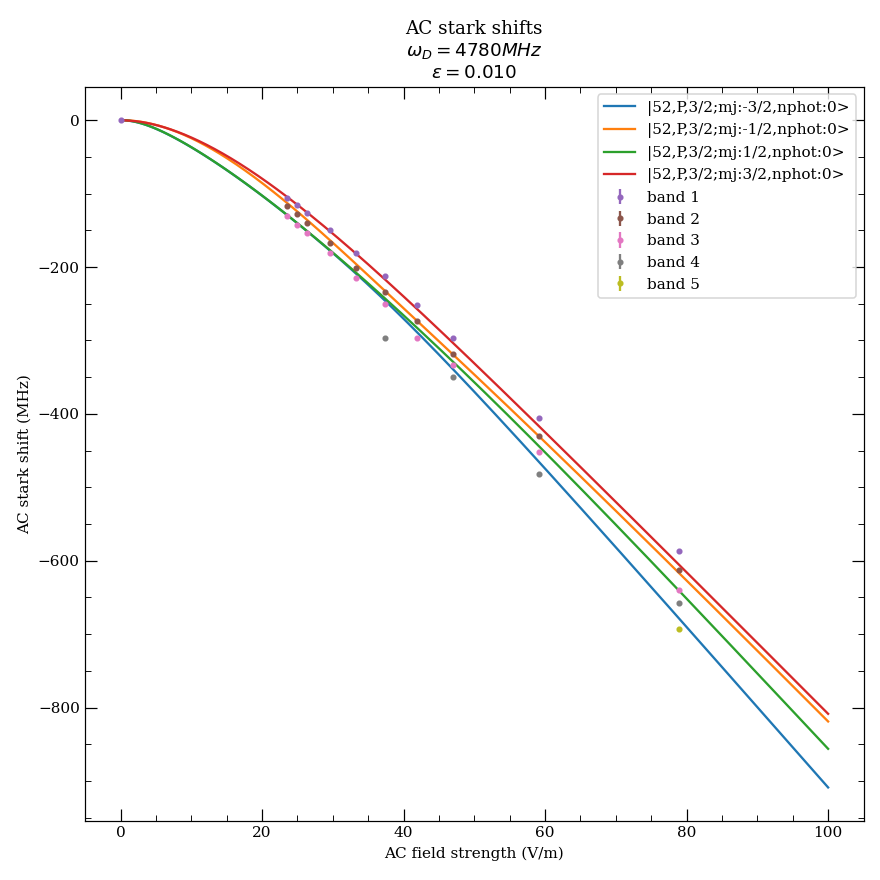

140
Levels :

[
	|52,S,1/2>,
	|52,P,1/2>,
	|52,P,3/2>,
	|51,D,3/2>,
	|51,D,5/2>,
	|53,S,1/2>
]
little_d built in 0.0019948482513427734
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.002991914749145508 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 0.0, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0029926300048828125s
Normalization Complete after 0.0019943714141845703 s
floquet_diag call completed in 0.00797891616821289s
Diagonalization complete for independent variable entry, value 0, 0.0
finding good eigenvectors for |level, n> = ||52,S,1/2>,-3>
finding good eigenvectors for |level, n> = ||52,S,1/2>,-2>
finding good eigenvectors for |level, n> = ||52,S,1/2>,-1>
finding good eigenvectors for |level, n> = ||52,S,1/2>,0>
finding good eigenvectors for |level, n> = ||52,S,1/2>,1>
finding good eigenvectors for |level, n> = ||52,S,1/2>,2>
finding good eigenvectors

C:\Users\Juan\Repos\two_photon_rydberg\floquet_hamiltonian.py:533: ComplexWarning: Casting complex values to real discards the imaginary part
  energies[inds[:, 1], i] = eigenvalues[inds[:, 0]]



floquet_diag call completed in 0.04756021499633789s
Diagonalization complete for independent variable entry, value 3, 0.3316582914572864
re-arrangement done after time 0.0029952526092529297s
little_d built in 0.002988576889038086
Hdc built in 0.0
Hfloquet put together in 0.0009987354278564453
Floquet matrix built after 0.003987312316894531 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 0.44221105527638194, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.041828155517578125s
Normalization Complete after 0.0019953250885009766 s
floquet_diag call completed in 0.04781079292297363s
Diagonalization complete for independent variable entry, value 4, 0.44221105527638194
re-arrangement done after time 0.002991914749145508s
little_d built in 0.0029916763305664062
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0029916763305664062 s
Begin Diagonalizing
Diagonalized Hfloquet

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 2.100502512562814, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04279136657714844s
Normalization Complete after 0.002043485641479492 s
floquet_diag call completed in 0.0498199462890625s
Diagonalization complete for independent variable entry, value 19, 2.100502512562814
re-arrangement done after time 0.002986907958984375s
little_d built in 0.0029892921447753906
Hdc built in 0.0
Hfloquet put together in 0.0009932518005371094
Floquet matrix built after 0.0039825439453125 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 2.21105527638191, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04197978973388672s
Normalization Complete after 0.0019948482513427734 s
floquet_diag call completed in 0.04795718193054199s
Diagonalization complete for independent variable entry, value 

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 3.869346733668342, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.043839454650878906s
Normalization Complete after 0.002031564712524414 s
floquet_diag call completed in 0.04982757568359375s
Diagonalization complete for independent variable entry, value 35, 3.869346733668342
re-arrangement done after time 0.002956867218017578s
little_d built in 0.003988981246948242
Hdc built in 0.0
Hfloquet put together in 0.001033782958984375
Floquet matrix built after 0.005022764205932617 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 3.9798994974874375, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.042810916900634766s
Normalization Complete after 0.0029914379119873047 s
floquet_diag call completed in 0.05082511901855469s
Diagonalization complete for independent variable entry, v

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 5.63819095477387, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0419921875s
Normalization Complete after 0.0029926300048828125 s
floquet_diag call completed in 0.047979116439819336s
Diagonalization complete for independent variable entry, value 51, 5.63819095477387
re-arrangement done after time 0.0020279884338378906s
little_d built in 0.0030002593994140625
Hdc built in 0.0
Hfloquet put together in 0.0009565353393554688
Floquet matrix built after 0.003956794738769531 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 5.748743718592965, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04305624961853027s
Normalization Complete after 0.0020263195037841797 s
floquet_diag call completed in 0.049039363861083984s
Diagonalization complete for independent variable entry, value 5

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 7.407035175879398, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04403567314147949s
Normalization Complete after 0.0009980201721191406 s
floquet_diag call completed in 0.05002093315124512s
Diagonalization complete for independent variable entry, value 67, 7.407035175879398
re-arrangement done after time 0.0030241012573242188s
little_d built in 0.0030014514923095703
Hdc built in 0.0
Hfloquet put together in 0.0009982585906982422
Floquet matrix built after 0.0039997100830078125 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 7.517587939698493, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04287910461425781s
Normalization Complete after 0.0019927024841308594 s
floquet_diag call completed in 0.048871517181396484s
Diagonalization complete for independent variable entry

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 9.175879396984925, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04411602020263672s
Normalization Complete after 0.0009970664978027344 s
floquet_diag call completed in 0.050096988677978516s
Diagonalization complete for independent variable entry, value 83, 9.175879396984925
re-arrangement done after time 0.0020275115966796875s
little_d built in 0.002991199493408203
Hdc built in 0.0
Hfloquet put together in 0.0009987354278564453
Floquet matrix built after 0.0039899349212646484 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 9.28643216080402, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04073905944824219s
Normalization Complete after 0.0019636154174804688 s
floquet_diag call completed in 0.047730445861816406s
Diagonalization complete for independent variable entry,

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 10.944723618090453, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0440523624420166s
Normalization Complete after 0.0019958019256591797 s
floquet_diag call completed in 0.05003762245178223s
Diagonalization complete for independent variable entry, value 99, 10.944723618090453
re-arrangement done after time 0.002033710479736328s
little_d built in 0.0029904842376708984
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0029904842376708984 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 11.055276381909549, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04199647903442383s
Normalization Complete after 0.0020275115966796875 s
floquet_diag call completed in 0.048009395599365234s
Diagonalization complete for independent variable entry, value 100, 11.0

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 12.713567839195981, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04296231269836426s
Normalization Complete after 0.0009644031524658203 s
floquet_diag call completed in 0.04891371726989746s
Diagonalization complete for independent variable entry, value 115, 12.713567839195981
re-arrangement done after time 0.002992391586303711s
little_d built in 0.002991914749145508
Hdc built in 0.0
Hfloquet put together in 0.000997781753540039
Floquet matrix built after 0.003989696502685547 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 12.824120603015077, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.041835784912109375s
Normalization Complete after 0.0020301342010498047 s
floquet_diag call completed in 0.04785561561584473s
Diagonalization complete for independent variable entry

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 14.482412060301508, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04355788230895996s
Normalization Complete after 0.0019943714141845703 s
floquet_diag call completed in 0.04854297637939453s
Diagonalization complete for independent variable entry, value 131, 14.482412060301508
re-arrangement done after time 0.00299072265625s
little_d built in 0.0029931068420410156
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0039920806884765625 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 14.592964824120603, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04307985305786133s
Normalization Complete after 0.001994609832763672 s
floquet_diag call completed in 0.04906654357910156s
Diagonalization complete for independent variable entry, value 132, 14.59296

Normalization Complete after 0.0020296573638916016 s
floquet_diag call completed in 0.04809737205505371s
Diagonalization complete for independent variable entry, value 147, 16.251256281407038
re-arrangement done after time 0.0029964447021484375s
little_d built in 0.0029866695404052734
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003985166549682617 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 16.36180904522613, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.042023658752441406s
Normalization Complete after 0.0020291805267333984 s
floquet_diag call completed in 0.04803800582885742s
Diagonalization complete for independent variable entry, value 148, 16.36180904522613
re-arrangement done after time 0.002991199493408203s
little_d built in 0.0029916763305664062
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003958225250244141 s
Begin D

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 18.020100502512562, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0436859130859375s
Normalization Complete after 0.001962423324584961 s
floquet_diag call completed in 0.04963803291320801s
Diagonalization complete for independent variable entry, value 163, 18.020100502512562
re-arrangement done after time 0.003024578094482422s
little_d built in 0.002995729446411133
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.002995729446411133 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 18.13065326633166, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.042989253997802734s
Normalization Complete after 0.00196075439453125 s
floquet_diag call completed in 0.04794573783874512s
Diagonalization complete for independent variable entry, value 164, 18.130653

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 19.78894472361809, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.043691158294677734s
Normalization Complete after 0.001953601837158203 s
floquet_diag call completed in 0.04961109161376953s
Diagonalization complete for independent variable entry, value 179, 19.78894472361809
re-arrangement done after time 0.003034830093383789s
little_d built in 0.0029914379119873047
Hdc built in 0.0
Hfloquet put together in 0.0009551048278808594
Floquet matrix built after 0.003946542739868164 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 19.899497487437188, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04108905792236328s
Normalization Complete after 0.0020284652709960938 s
floquet_diag call completed in 0.04706406593322754s
Diagonalization complete for independent variable entry,

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 21.55778894472362, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04315042495727539s
Normalization Complete after 0.001994609832763672 s
floquet_diag call completed in 0.04913496971130371s
Diagonalization complete for independent variable entry, value 195, 21.55778894472362
re-arrangement done after time 0.002991914749145508s
little_d built in 0.002991914749145508
Hdc built in 0.0009982585906982422
Hfloquet put together in 0.0
Floquet matrix built after 0.00399017333984375 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 21.668341708542716, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04282951354980469s
Normalization Complete after 0.0010035037994384766 s
floquet_diag call completed in 0.04881405830383301s
Diagonalization complete for independent variable entry, va

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 26.415477386934672, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04322052001953125s
Normalization Complete after 0.0019979476928710938 s
floquet_diag call completed in 0.049222707748413086s
Diagonalization complete for independent variable entry, value 211, 26.415477386934672
re-arrangement done after time 0.0029489994049072266s
little_d built in 0.003034353256225586
Hdc built in 0.0009560585021972656
Hfloquet put together in 0.0
Floquet matrix built after 0.0039904117584228516 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 26.806884422110553, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.041845083236694336s
Normalization Complete after 0.0027174949645996094 s
floquet_diag call completed in 0.0485529899597168s
Diagonalization complete for independent variable en

Normalization Complete after 0.0019931793212890625 s
floquet_diag call completed in 0.048963308334350586s
Diagonalization complete for independent variable entry, value 227, 32.67798994974874
re-arrangement done after time 0.0029947757720947266s
little_d built in 0.002993345260620117
Hdc built in 0.0
Hfloquet put together in 0.0009965896606445312
Floquet matrix built after 0.0039899349212646484 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 33.06939698492462, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04411125183105469s
Normalization Complete after 0.002026796340942383 s
floquet_diag call completed in 0.05012798309326172s
Diagonalization complete for independent variable entry, value 228, 33.06939698492462
re-arrangement done after time 0.0029942989349365234s
little_d built in 0.0029914379119873047
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.00299143791

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 38.940502512562816, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04330253601074219s
Normalization Complete after 0.001992464065551758 s
floquet_diag call completed in 0.04928278923034668s
Diagonalization complete for independent variable entry, value 243, 38.940502512562816
re-arrangement done after time 0.002992391586303711s
little_d built in 0.002993345260620117
Hdc built in 0.0
Hfloquet put together in 0.0010046958923339844
Floquet matrix built after 0.0039980411529541016 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 39.33190954773869, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04286479949951172s
Normalization Complete after 0.001995086669921875 s
floquet_diag call completed in 0.049855947494506836s
Diagonalization complete for independent variable entry,

Normalization Complete after 0.001031637191772461 s
floquet_diag call completed in 0.049237966537475586s
Diagonalization complete for independent variable entry, value 259, 45.20301507537688
re-arrangement done after time 0.0029604434967041016s
little_d built in 0.0029921531677246094
Hdc built in 0.0
Hfloquet put together in 0.000997304916381836
Floquet matrix built after 0.003989458084106445 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 45.59442211055276, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04380154609680176s
Normalization Complete after 0.002027750015258789 s
floquet_diag call completed in 0.04981875419616699s
Diagonalization complete for independent variable entry, value 260, 45.59442211055276
re-arrangement done after time 0.002992391586303711s
little_d built in 0.0029914379119873047
Hdc built in 0.0010001659393310547
Hfloquet put together in 0.0
Floquet matrix built afte

Normalization Complete after 0.0030264854431152344 s
floquet_diag call completed in 0.04955267906188965s
Diagonalization complete for independent variable entry, value 275, 51.46552763819095
re-arrangement done after time 0.001992940902709961s
little_d built in 0.002992391586303711
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.002992391586303711 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 51.85693467336684, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04384803771972656s
Normalization Complete after 0.002027273178100586 s
floquet_diag call completed in 0.04886770248413086s
Diagonalization complete for independent variable entry, value 276, 51.85693467336684
re-arrangement done after time 0.0029914379119873047s
little_d built in 0.0029921531677246094
Hdc built in 0.0
Hfloquet put together in 0.0009989738464355469
Floquet matrix built after 0.00399112701416

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 57.72804020100502, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04299187660217285s
Normalization Complete after 0.0020384788513183594 s
floquet_diag call completed in 0.05000925064086914s
Diagonalization complete for independent variable entry, value 291, 57.72804020100502
re-arrangement done after time 0.002983570098876953s
little_d built in 0.0029892921447753906
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0029892921447753906 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 58.1194472361809, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.044361114501953125s
Normalization Complete after 0.0019943714141845703 s
floquet_diag call completed in 0.050343990325927734s
Diagonalization complete for independent variable entry, value 292, 58.11

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 63.990552763819096, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04483771324157715s
Normalization Complete after 0.0019981861114501953 s
floquet_diag call completed in 0.05181694030761719s
Diagonalization complete for independent variable entry, value 307, 63.990552763819096
re-arrangement done after time 0.001995086669921875s
little_d built in 0.003023386001586914
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003023386001586914 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 64.38195979899497, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04343008995056152s
Normalization Complete after 0.001994609832763672 s
floquet_diag call completed in 0.04844808578491211s
Diagonalization complete for independent variable entry, value 308, 64.3819

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 70.25306532663316, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.044130563735961914s
Normalization Complete after 0.002031564712524414 s
floquet_diag call completed in 0.049154043197631836s
Diagonalization complete for independent variable entry, value 323, 70.25306532663316
re-arrangement done after time 0.002988576889038086s
little_d built in 0.0029935836791992188
Hdc built in 0.0
Hfloquet put together in 0.0009980201721191406
Floquet matrix built after 0.003991603851318359 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 70.64447236180905, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0429224967956543s
Normalization Complete after 0.0020127296447753906 s
floquet_diag call completed in 0.04892683029174805s
Diagonalization complete for independent variable entry, 

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 76.51557788944723, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.042536020278930664s
Normalization Complete after 0.003025054931640625 s
floquet_diag call completed in 0.049550771713256836s
Diagonalization complete for independent variable entry, value 339, 76.51557788944723
re-arrangement done after time 0.002993345260620117s
little_d built in 0.0029916763305664062
Hdc built in 0.0
Hfloquet put together in 0.0010018348693847656
Floquet matrix built after 0.003993511199951172 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 76.90698492462312, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.043683767318725586s
Normalization Complete after 0.0019943714141845703 s
floquet_diag call completed in 0.04967164993286133s
Diagonalization complete for independent variable entry

Normalization Complete after 0.001995086669921875 s
floquet_diag call completed in 0.051876068115234375s
Diagonalization complete for independent variable entry, value 355, 82.7780904522613
re-arrangement done after time 0.0029609203338623047s
little_d built in 0.002991914749145508
Hdc built in 0.0009975433349609375
Hfloquet put together in 0.0
Floquet matrix built after 0.003989458084106445 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 83.16949748743718, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04388165473937988s
Normalization Complete after 0.0020263195037841797 s
floquet_diag call completed in 0.04989743232727051s
Diagonalization complete for independent variable entry, value 356, 83.16949748743718
re-arrangement done after time 0.0019953250885009766s
little_d built in 0.002991914749145508
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.00299191474914

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 89.04060301507538, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.043787240982055664s
Normalization Complete after 0.002992868423461914 s
floquet_diag call completed in 0.05077004432678223s
Diagonalization complete for independent variable entry, value 371, 89.04060301507538
re-arrangement done after time 0.0029909610748291016s
little_d built in 0.0029921531677246094
Hdc built in 0.0
Hfloquet put together in 0.0009999275207519531
Floquet matrix built after 0.0039920806884765625 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 89.43201005025125, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04387617111206055s
Normalization Complete after 0.0020270347595214844 s
floquet_diag call completed in 0.049895286560058594s
Diagonalization complete for independent variable entr

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 95.30311557788944, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.044734954833984375s
Normalization Complete after 0.0019960403442382812 s
floquet_diag call completed in 0.049764156341552734s
Diagonalization complete for independent variable entry, value 387, 95.30311557788944
re-arrangement done after time 0.002991914749145508s
little_d built in 0.003021717071533203
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003021717071533203 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 95.69452261306532, ellipticity 0.015, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04447126388549805s
Normalization Complete after 0.001993894577026367 s
floquet_diag call completed in 0.050484418869018555s
Diagonalization complete for independent variable entry, value 388, 95.694

<IPython.core.display.Javascript object>


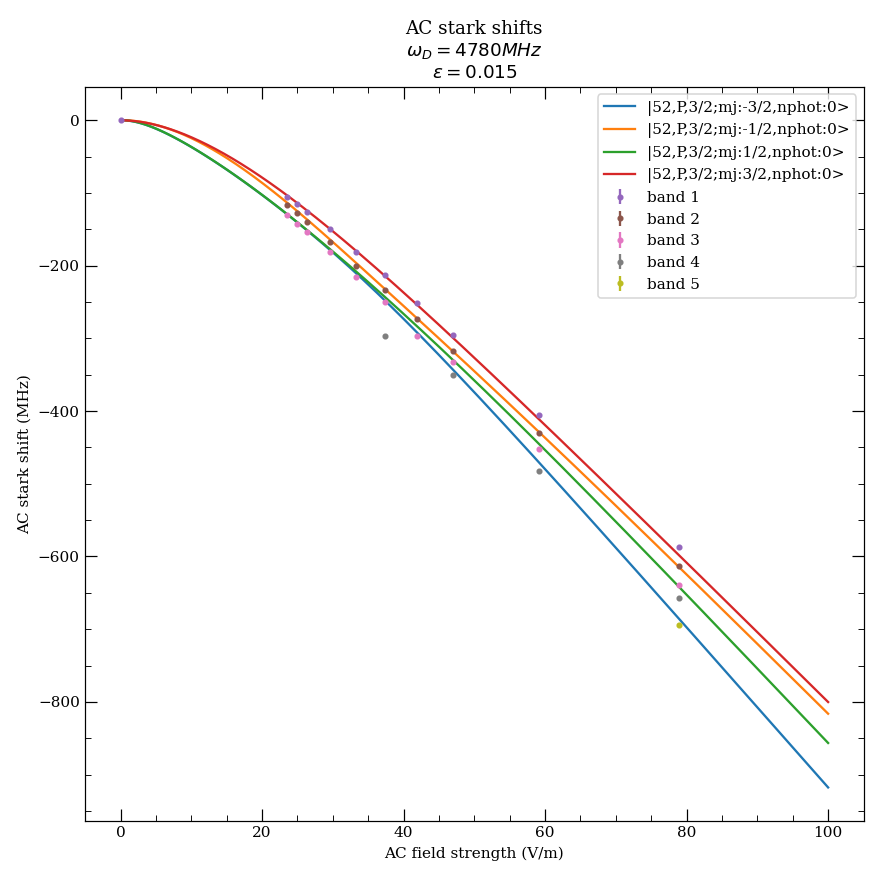

140
Levels :

[
	|52,S,1/2>,
	|52,P,1/2>,
	|52,P,3/2>,
	|51,D,3/2>,
	|51,D,5/2>,
	|53,S,1/2>
]
little_d built in 0.0029916763305664062
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0029916763305664062 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 0.0, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0028324127197265625s
Normalization Complete after 0.001996755599975586 s
floquet_diag call completed in 0.007820844650268555s
Diagonalization complete for independent variable entry, value 0, 0.0
finding good eigenvectors for |level, n> = ||52,S,1/2>,-3>
finding good eigenvectors for |level, n> = ||52,S,1/2>,-2>
finding good eigenvectors for |level, n> = ||52,S,1/2>,-1>
finding good eigenvectors for |level, n> = ||52,S,1/2>,0>
finding good eigenvectors for |level, n> = ||52,S,1/2>,1>
finding good eigenvectors for |level, n> = ||52,S,1/2>,2>
finding good eigenvectors

C:\Users\Juan\Repos\two_photon_rydberg\floquet_hamiltonian.py:533: ComplexWarning: Casting complex values to real discards the imaginary part
  energies[inds[:, 1], i] = eigenvalues[inds[:, 0]]


Hdc built in 0.0
Hfloquet put together in 0.000997304916381836
Floquet matrix built after 0.004019737243652344 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 0.44221105527638194, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04288673400878906s
Normalization Complete after 0.0019943714141845703 s
floquet_diag call completed in 0.04890084266662598s
Diagonalization complete for independent variable entry, value 4, 0.44221105527638194
re-arrangement done after time 0.0019941329956054688s
little_d built in 0.003988981246948242
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003988981246948242 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 0.5527638190954774, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04357028007507324s
Normalization Complete after 0.001992225646972

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 2.100502512562814, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04243350028991699s
Normalization Complete after 0.0019550323486328125 s
floquet_diag call completed in 0.048380136489868164s
Diagonalization complete for independent variable entry, value 19, 2.100502512562814
re-arrangement done after time 0.0030248165130615234s
little_d built in 0.0029935836791992188
Hdc built in 0.0009963512420654297
Hfloquet put together in 0.0
Floquet matrix built after 0.0039899349212646484 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 2.21105527638191, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.043183088302612305s
Normalization Complete after 0.0009980201721191406 s
floquet_diag call completed in 0.05016326904296875s
Diagonalization complete for independent variable entry, 

Normalization Complete after 0.0019953250885009766 s
floquet_diag call completed in 0.04941725730895996s
Diagonalization complete for independent variable entry, value 35, 3.869346733668342
re-arrangement done after time 0.0029909610748291016s
little_d built in 0.002991914749145508
Hdc built in 0.00099945068359375
Hfloquet put together in 0.0
Floquet matrix built after 0.003991365432739258 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 3.9798994974874375, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.043848276138305664s
Normalization Complete after 0.0020275115966796875 s
floquet_diag call completed in 0.04986715316772461s
Diagonalization complete for independent variable entry, value 36, 3.9798994974874375
re-arrangement done after time 0.0029931068420410156s
little_d built in 0.0029904842376708984
Hdc built in 0.0
Hfloquet put together in 0.0009989738464355469
Floquet matrix built afte

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 5.63819095477387, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04237484931945801s
Normalization Complete after 0.0030336380004882812 s
floquet_diag call completed in 0.049397945404052734s
Diagonalization complete for independent variable entry, value 51, 5.63819095477387
re-arrangement done after time 0.001995086669921875s
little_d built in 0.0029914379119873047
Hdc built in 0.0009970664978027344
Hfloquet put together in 0.0
Floquet matrix built after 0.003988504409790039 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 5.748743718592965, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0428776741027832s
Normalization Complete after 0.001993894577026367 s
floquet_diag call completed in 0.04886007308959961s
Diagonalization complete for independent variable entry, value 

Normalization Complete after 0.0019843578338623047 s
floquet_diag call completed in 0.04820084571838379s
Diagonalization complete for independent variable entry, value 67, 7.407035175879398
re-arrangement done after time 0.002991914749145508s
little_d built in 0.004025459289550781
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.004025459289550781 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 7.517587939698493, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04384660720825195s
Normalization Complete after 0.002026796340942383 s
floquet_diag call completed in 0.04989886283874512s
Diagonalization complete for independent variable entry, value 68, 7.517587939698493
re-arrangement done after time 0.0031604766845703125s
little_d built in 0.0029916763305664062
Hdc built in 0.0
Hfloquet put together in 0.000997781753540039
Floquet matrix built after 0.003989458084106445

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 9.175879396984925, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04339146614074707s
Normalization Complete after 0.003021717071533203 s
floquet_diag call completed in 0.05040931701660156s
Diagonalization complete for independent variable entry, value 83, 9.175879396984925
re-arrangement done after time 0.001987934112548828s
little_d built in 0.0029916763305664062
Hdc built in 0.0
Hfloquet put together in 0.0010111331939697266
Floquet matrix built after 0.004002809524536133 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 9.28643216080402, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.044189453125s
Normalization Complete after 0.002024412155151367 s
floquet_diag call completed in 0.0502166748046875s
Diagonalization complete for independent variable entry, value 84, 9.

Normalization Complete after 0.0020210742950439453 s
floquet_diag call completed in 0.04870867729187012s
Diagonalization complete for independent variable entry, value 99, 10.944723618090453
re-arrangement done after time 0.0029926300048828125s
little_d built in 0.003956317901611328
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003956317901611328 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 11.055276381909549, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04260563850402832s
Normalization Complete after 0.0019958019256591797 s
floquet_diag call completed in 0.04855775833129883s
Diagonalization complete for independent variable entry, value 100, 11.055276381909549
re-arrangement done after time 0.0029904842376708984s
little_d built in 0.0029921531677246094
Hdc built in 0.0
Hfloquet put together in 0.0009989738464355469
Floquet matrix built after 0.00399112701

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 12.713567839195981, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.042697906494140625s
Normalization Complete after 0.0019583702087402344 s
floquet_diag call completed in 0.04864692687988281s
Diagonalization complete for independent variable entry, value 115, 12.713567839195981
re-arrangement done after time 0.0030241012573242188s
little_d built in 0.0030012130737304688
Hdc built in 0.0
Hfloquet put together in 0.0009553432464599609
Floquet matrix built after 0.00395655632019043 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 12.824120603015077, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04195690155029297s
Normalization Complete after 0.0030241012573242188 s
floquet_diag call completed in 0.04893755912780762s
Diagonalization complete for independent variable entry

Normalization Complete after 0.001996278762817383 s
floquet_diag call completed in 0.0498051643371582s
Diagonalization complete for independent variable entry, value 131, 14.482412060301508
re-arrangement done after time 0.002955913543701172s
little_d built in 0.0029909610748291016
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0029909610748291016 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 14.592964824120603, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04391837120056152s
Normalization Complete after 0.0019919872283935547 s
floquet_diag call completed in 0.04890131950378418s
Diagonalization complete for independent variable entry, value 132, 14.592964824120603
re-arrangement done after time 0.0029916763305664062s
little_d built in 0.003991603851318359
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003991603851318359 s
Begin Dia

Normalization Complete after 0.001996755599975586 s
floquet_diag call completed in 0.048063039779663086s
Diagonalization complete for independent variable entry, value 147, 16.251256281407038
re-arrangement done after time 0.002989530563354492s
little_d built in 0.002991914749145508
Hdc built in 0.0
Hfloquet put together in 0.000997781753540039
Floquet matrix built after 0.003989696502685547 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 16.36180904522613, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04188704490661621s
Normalization Complete after 0.001996278762817383 s
floquet_diag call completed in 0.04787302017211914s
Diagonalization complete for independent variable entry, value 148, 16.36180904522613
re-arrangement done after time 0.0029914379119873047s
little_d built in 0.003989219665527344
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0039892196655273

Diagonalized after time: 0.042351484298706055s
Normalization Complete after 0.003031492233276367 s
floquet_diag call completed in 0.04837226867675781s
Diagonalization complete for independent variable entry, value 163, 18.020100502512562
re-arrangement done after time 0.0029494762420654297s
little_d built in 0.003034830093383789
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003989458084106445 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 18.13065326633166, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.043356895446777344s
Normalization Complete after 0.0020265579223632812 s
floquet_diag call completed in 0.04937291145324707s
Diagonalization complete for independent variable entry, value 164, 18.13065326633166
re-arrangement done after time 0.002960681915283203s
little_d built in 0.003022909164428711
Hdc built in 0.0
Hfloquet put together in 0.0010011196136474

Normalization Complete after 0.0010027885437011719 s
floquet_diag call completed in 0.049180030822753906s
Diagonalization complete for independent variable entry, value 179, 19.78894472361809
re-arrangement done after time 0.002991199493408203s
little_d built in 0.0029935836791992188
Hdc built in 0.0
Hfloquet put together in 0.0009953975677490234
Floquet matrix built after 0.003988981246948242 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 19.899497487437188, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04189467430114746s
Normalization Complete after 0.001987934112548828 s
floquet_diag call completed in 0.04787158966064453s
Diagonalization complete for independent variable entry, value 180, 19.899497487437188
re-arrangement done after time 0.0019953250885009766s
little_d built in 0.002998828887939453
Hdc built in 0.0
Hfloquet put together in 0.000997781753540039
Floquet matrix built aft

Normalization Complete after 0.0030257701873779297 s
floquet_diag call completed in 0.04795098304748535s
Diagonalization complete for independent variable entry, value 195, 21.55778894472362
re-arrangement done after time 0.0019626617431640625s
little_d built in 0.002992391586303711
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.002992391586303711 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 21.668341708542716, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04317188262939453s
Normalization Complete after 0.002029895782470703 s
floquet_diag call completed in 0.048194169998168945s
Diagonalization complete for independent variable entry, value 196, 21.668341708542716
re-arrangement done after time 0.0029942989349365234s
little_d built in 0.002991199493408203
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.002991199493408203 s
Begin Dia

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 26.415477386934672, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04297614097595215s
Normalization Complete after 0.002035856246948242 s
floquet_diag call completed in 0.05000162124633789s
Diagonalization complete for independent variable entry, value 211, 26.415477386934672
re-arrangement done after time 0.0019521713256835938s
little_d built in 0.0030341148376464844
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0030341148376464844 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 26.806884422110553, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.043842315673828125s
Normalization Complete after 0.0019941329956054688 s
floquet_diag call completed in 0.04986739158630371s
Diagonalization complete for independent variable entry, value 212, 26.8

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 32.67798994974874, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04285240173339844s
Normalization Complete after 0.0020461082458496094 s
floquet_diag call completed in 0.04892158508300781s
Diagonalization complete for independent variable entry, value 227, 32.67798994974874
re-arrangement done after time 0.002982616424560547s
little_d built in 0.0029904842376708984
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003988504409790039 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 33.06939698492462, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04310727119445801s
Normalization Complete after 0.0020253658294677734 s
floquet_diag call completed in 0.04912114143371582s
Diagonalization complete for independent variable entry, value 228, 33.069396

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 38.940502512562816, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04385256767272949s
Normalization Complete after 0.0020334720611572266 s
floquet_diag call completed in 0.04987311363220215s
Diagonalization complete for independent variable entry, value 243, 38.940502512562816
re-arrangement done after time 0.0029861927032470703s
little_d built in 0.002991199493408203
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003987789154052734 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 39.33190954773869, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04172468185424805s
Normalization Complete after 0.0020287036895751953 s
floquet_diag call completed in 0.04774117469787598s
Diagonalization complete for independent variable entry, value 244, 39.3319

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 45.20301507537688, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04439902305603027s
Normalization Complete after 0.001991748809814453 s
floquet_diag call completed in 0.049382686614990234s
Diagonalization complete for independent variable entry, value 259, 45.20301507537688
re-arrangement done after time 0.001998424530029297s
little_d built in 0.003984212875366211
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003984212875366211 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 45.59442211055276, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04382443428039551s
Normalization Complete after 0.001994609832763672 s
floquet_diag call completed in 0.04980325698852539s
Diagonalization complete for independent variable entry, value 260, 45.59442211

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 51.46552763819095, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04306197166442871s
Normalization Complete after 0.002026796340942383 s
floquet_diag call completed in 0.04907941818237305s
Diagonalization complete for independent variable entry, value 275, 51.46552763819095
re-arrangement done after time 0.0029921531677246094s
little_d built in 0.002995729446411133
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0039823055267333984 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 51.85693467336684, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.043365478515625s
Normalization Complete after 0.0019750595092773438 s
floquet_diag call completed in 0.04932284355163574s
Diagonalization complete for independent variable entry, value 276, 51.85693467

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 57.72804020100502, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.043087005615234375s
Normalization Complete after 0.0009887218475341797 s
floquet_diag call completed in 0.049017906188964844s
Diagonalization complete for independent variable entry, value 291, 57.72804020100502
re-arrangement done after time 0.003010988235473633s
little_d built in 0.0029921531677246094
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0029921531677246094 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 58.1194472361809, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.044567108154296875s
Normalization Complete after 0.001994609832763672 s
floquet_diag call completed in 0.049553871154785156s
Diagonalization complete for independent variable entry, value 292, 58.119

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 63.990552763819096, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04300260543823242s
Normalization Complete after 0.0019860267639160156 s
floquet_diag call completed in 0.04897713661193848s
Diagonalization complete for independent variable entry, value 307, 63.990552763819096
re-arrangement done after time 0.0020089149475097656s
little_d built in 0.0029904842376708984
Hdc built in 0.0
Hfloquet put together in 0.0009653568267822266
Floquet matrix built after 0.003955841064453125 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 64.38195979899497, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.044113874435424805s
Normalization Complete after 0.003027677536010742 s
floquet_diag call completed in 0.05109739303588867s
Diagonalization complete for independent variable entry,

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 70.25306532663316, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04417610168457031s
Normalization Complete after 0.0019943714141845703 s
floquet_diag call completed in 0.05015921592712402s
Diagonalization complete for independent variable entry, value 323, 70.25306532663316
re-arrangement done after time 0.0019884109497070312s
little_d built in 0.0030007362365722656
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0030007362365722656 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 70.64447236180905, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.045525550842285156s
Normalization Complete after 0.00102996826171875 s
floquet_diag call completed in 0.050553083419799805s
Diagonalization complete for independent variable entry, value 324, 70.6444

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 76.51557788944723, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.042746543884277344s
Normalization Complete after 0.0020270347595214844 s
floquet_diag call completed in 0.04876446723937988s
Diagonalization complete for independent variable entry, value 339, 76.51557788944723
re-arrangement done after time 0.002997875213623047s
little_d built in 0.0029535293579101562
Hdc built in 0.0
Hfloquet put together in 0.0010318756103515625
Floquet matrix built after 0.003985404968261719 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 76.90698492462312, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.042890310287475586s
Normalization Complete after 0.0019958019256591797 s
floquet_diag call completed in 0.048871517181396484s
Diagonalization complete for independent variable entry,

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 82.7780904522613, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04400277137756348s
Normalization Complete after 0.0019979476928710938 s
floquet_diag call completed in 0.0500028133392334s
Diagonalization complete for independent variable entry, value 355, 82.7780904522613
re-arrangement done after time 0.0030214786529541016s
little_d built in 0.002991914749145508
Hdc built in 0.0009970664978027344
Hfloquet put together in 0.0
Floquet matrix built after 0.003988981246948242 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 83.16949748743718, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.045412302017211914s
Normalization Complete after 0.002026796340942383 s
floquet_diag call completed in 0.05142807960510254s
Diagonalization complete for independent variable entry, value

Normalization Complete after 0.0019931793212890625 s
floquet_diag call completed in 0.05102682113647461s
Diagonalization complete for independent variable entry, value 371, 89.04060301507538
re-arrangement done after time 0.002960681915283203s
little_d built in 0.0029916763305664062
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003988981246948242 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 89.43201005025125, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04393744468688965s
Normalization Complete after 0.0020275115966796875 s
floquet_diag call completed in 0.04995393753051758s
Diagonalization complete for independent variable entry, value 372, 89.43201005025125
re-arrangement done after time 0.002992391586303711s
little_d built in 0.0029914379119873047
Hdc built in 0.0
Hfloquet put together in 0.0009949207305908203
Floquet matrix built after 0.00398635864257

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 95.30311557788944, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.043425559997558594s
Normalization Complete after 0.0019941329956054688 s
floquet_diag call completed in 0.049410104751586914s
Diagonalization complete for independent variable entry, value 387, 95.30311557788944
re-arrangement done after time 0.001995563507080078s
little_d built in 0.002991914749145508
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.002991914749145508 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 95.69452261306532, ellipticity 0.02, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04492592811584473s
Normalization Complete after 0.0020270347595214844 s
floquet_diag call completed in 0.04994487762451172s
Diagonalization complete for independent variable entry, value 388, 95.69452

<IPython.core.display.Javascript object>


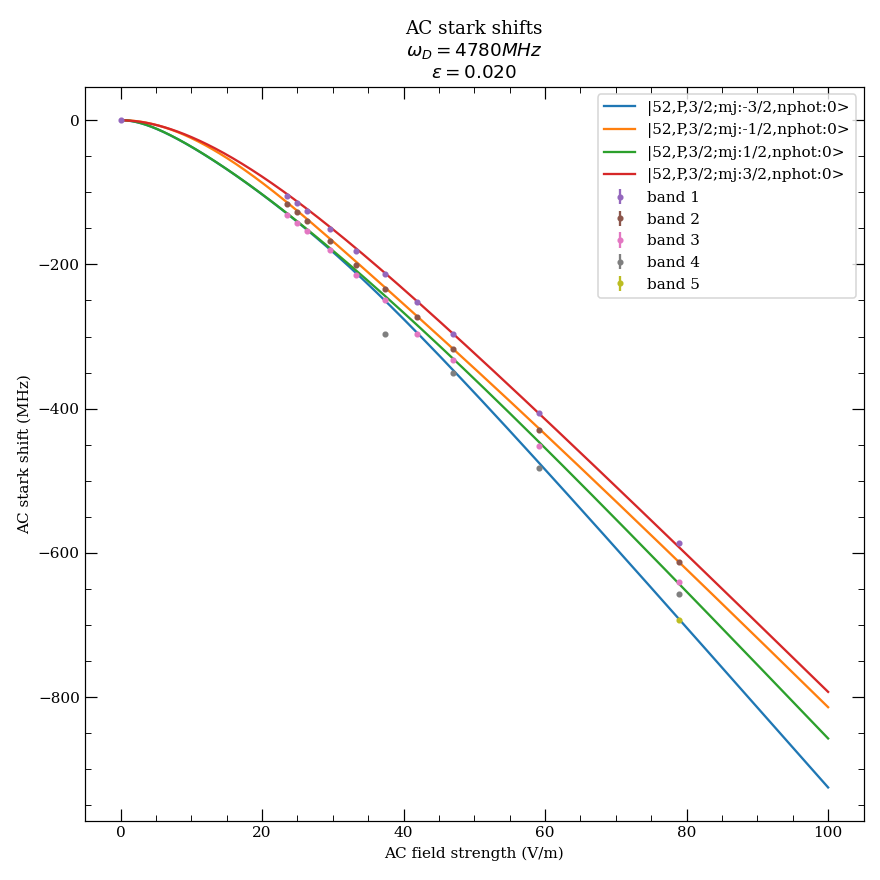

140
Levels :

[
	|52,S,1/2>,
	|52,P,1/2>,
	|52,P,3/2>,
	|51,D,3/2>,
	|51,D,5/2>,
	|53,S,1/2>
]
little_d built in 0.002991914749145508
Hdc built in 0.0
Hfloquet put together in 0.0009942054748535156
Floquet matrix built after 0.0039861202239990234 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 0.0, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0029611587524414062s
Normalization Complete after 0.001993894577026367 s
floquet_diag call completed in 0.008941173553466797s
Diagonalization complete for independent variable entry, value 0, 0.0
finding good eigenvectors for |level, n> = ||52,S,1/2>,-3>
finding good eigenvectors for |level, n> = ||52,S,1/2>,-2>
finding good eigenvectors for |level, n> = ||52,S,1/2>,-1>
finding good eigenvectors for |level, n> = ||52,S,1/2>,0>
finding good eigenvectors for |level, n> = ||52,S,1/2>,1>
finding good eigenvectors for |level, n> = ||52,S,1/2>,2>
finding

C:\Users\Juan\Repos\two_photon_rydberg\floquet_hamiltonian.py:533: ComplexWarning: Casting complex values to real discards the imaginary part
  energies[inds[:, 1], i] = eigenvalues[inds[:, 0]]



floquet_diag call completed in 0.04873514175415039s
Diagonalization complete for independent variable entry, value 3, 0.3316582914572864
re-arrangement done after time 0.0019614696502685547s
little_d built in 0.002991914749145508
Hdc built in 0.0
Hfloquet put together in 0.0009996891021728516
Floquet matrix built after 0.003991603851318359 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 0.44221105527638194, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04384660720825195s
Normalization Complete after 0.0009968280792236328 s
floquet_diag call completed in 0.04983234405517578s
Diagonalization complete for independent variable entry, value 4, 0.44221105527638194
re-arrangement done after time 0.0027647018432617188s
little_d built in 0.003025054931640625
Hdc built in 0.0
Hfloquet put together in 0.0009965896606445312
Floquet matrix built after 0.004021644592285156 s
Begin Diagonalizing
Diago

Normalization Complete after 0.0020294189453125 s
floquet_diag call completed in 0.04833030700683594s
Diagonalization complete for independent variable entry, value 19, 2.100502512562814
re-arrangement done after time 0.002994060516357422s
little_d built in 0.0029878616333007812
Hdc built in 0.0
Hfloquet put together in 0.000997781753540039
Floquet matrix built after 0.00398564338684082 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 2.21105527638191, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04189467430114746s
Normalization Complete after 0.0029532909393310547 s
floquet_diag call completed in 0.048833608627319336s
Diagonalization complete for independent variable entry, value 20, 2.21105527638191
re-arrangement done after time 0.0030236244201660156s
little_d built in 0.002991914749145508
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.002991914749145508 s


Normalization Complete after 0.0020270347595214844 s
floquet_diag call completed in 0.05060696601867676s
Diagonalization complete for independent variable entry, value 35, 3.869346733668342
re-arrangement done after time 0.0029914379119873047s
little_d built in 0.003990650177001953
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003990650177001953 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 3.9798994974874375, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04418683052062988s
Normalization Complete after 0.0009965896606445312 s
floquet_diag call completed in 0.05117225646972656s
Diagonalization complete for independent variable entry, value 36, 3.9798994974874375
re-arrangement done after time 0.0020246505737304688s
little_d built in 0.0029916763305664062
Hdc built in 0.0
Hfloquet put together in 0.001007080078125
Floquet matrix built after 0.0039987564086914

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 5.63819095477387, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0434412956237793s
Normalization Complete after 0.002040386199951172 s
floquet_diag call completed in 0.0494687557220459s
Diagonalization complete for independent variable entry, value 51, 5.63819095477387
re-arrangement done after time 0.0029451847076416016s
little_d built in 0.0030333995819091797
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0030333995819091797 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 5.748743718592965, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.044328927993774414s
Normalization Complete after 0.0019927024841308594 s
floquet_diag call completed in 0.04935503005981445s
Diagonalization complete for independent variable entry, value 52, 5.748743718

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 7.407035175879398, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.042969465255737305s
Normalization Complete after 0.0019965171813964844 s
floquet_diag call completed in 0.04895734786987305s
Diagonalization complete for independent variable entry, value 67, 7.407035175879398
re-arrangement done after time 0.002990245819091797s
little_d built in 0.0030243396759033203
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.004021406173706055 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 7.517587939698493, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04343008995056152s
Normalization Complete after 0.0019855499267578125 s
floquet_diag call completed in 0.04943704605102539s
Diagonalization complete for independent variable entry, value 68, 7.517587

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 9.175879396984925, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04527878761291504s
Normalization Complete after 0.0019941329956054688 s
floquet_diag call completed in 0.05030226707458496s
Diagonalization complete for independent variable entry, value 83, 9.175879396984925
re-arrangement done after time 0.0029914379119873047s
little_d built in 0.0030243396759033203
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0030243396759033203 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 9.28643216080402, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04409193992614746s
Normalization Complete after 0.002028226852416992 s
floquet_diag call completed in 0.0501399040222168s
Diagonalization complete for independent variable entry, value 84, 9.28643216

Diagonalized after time: 0.043386220932006836s
Normalization Complete after 0.0020265579223632812 s
floquet_diag call completed in 0.050414323806762695s
Diagonalization complete for independent variable entry, value 99, 10.944723618090453
re-arrangement done after time 0.002956867218017578s
little_d built in 0.0030274391174316406
Hdc built in 0.0
Hfloquet put together in 0.0009989738464355469
Floquet matrix built after 0.0040264129638671875 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 11.055276381909549, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04296302795410156s
Normalization Complete after 0.0020275115966796875 s
floquet_diag call completed in 0.04901695251464844s
Diagonalization complete for independent variable entry, value 100, 11.055276381909549
re-arrangement done after time 0.0019979476928710938s
little_d built in 0.0029904842376708984
Hdc built in 0.0
Hfloquet put togeth

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 12.713567839195981, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.042688846588134766s
Normalization Complete after 0.001992940902709961 s
floquet_diag call completed in 0.04767346382141113s
Diagonalization complete for independent variable entry, value 115, 12.713567839195981
re-arrangement done after time 0.0030341148376464844s
little_d built in 0.0029916763305664062
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0029916763305664062 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 12.824120603015077, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04510641098022461s
Normalization Complete after 0.0019953250885009766 s
floquet_diag call completed in 0.05009341239929199s
Diagonalization complete for independent variable entry, value 116, 12

Normalization Complete after 0.0009968280792236328 s
floquet_diag call completed in 0.048731088638305664s
Diagonalization complete for independent variable entry, value 131, 14.482412060301508
re-arrangement done after time 0.0030350685119628906s
little_d built in 0.002994537353515625
Hdc built in 0.0
Hfloquet put together in 0.0009984970092773438
Floquet matrix built after 0.003993034362792969 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 14.592964824120603, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04283857345581055s
Normalization Complete after 0.002026081085205078 s
floquet_diag call completed in 0.048857688903808594s
Diagonalization complete for independent variable entry, value 132, 14.592964824120603
re-arrangement done after time 0.002992868423461914s
little_d built in 0.002994537353515625
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0029945373

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 16.251256281407038, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.042653560638427734s
Normalization Complete after 0.0009980201721191406 s
floquet_diag call completed in 0.04863595962524414s
Diagonalization complete for independent variable entry, value 147, 16.251256281407038
re-arrangement done after time 0.0029921531677246094s
little_d built in 0.0029916763305664062
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0039882659912109375 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 16.36180904522613, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04273533821105957s
Normalization Complete after 0.001994609832763672 s
floquet_diag call completed in 0.04871821403503418s
Diagonalization complete for independent variable entry, value 148, 16.

DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04144287109375s
Normalization Complete after 0.0019614696502685547 s
floquet_diag call completed in 0.04639601707458496s
Diagonalization complete for independent variable entry, value 163, 18.020100502512562
re-arrangement done after time 0.0019600391387939453s
little_d built in 0.0029811859130859375
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.004021644592285156 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 18.13065326633166, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04423975944519043s
Normalization Complete after 0.0009987354278564453 s
floquet_diag call completed in 0.050258636474609375s
Diagonalization complete for independent variable entry, value 164, 18.13065326633166
re-arrangement done after time 0.0019931793212890625s
little_d built in 0.0029897689819335938
Hdc built in 0.0
Hfloquet pu

Normalization Complete after 0.0020284652709960938 s
floquet_diag call completed in 0.04722189903259277s
Diagonalization complete for independent variable entry, value 179, 19.78894472361809
re-arrangement done after time 0.0029964447021484375s
little_d built in 0.0029871463775634766
Hdc built in 0.0
Hfloquet put together in 0.0010128021240234375
Floquet matrix built after 0.003999948501586914 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 19.899497487437188, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0418698787689209s
Normalization Complete after 0.002035379409790039 s
floquet_diag call completed in 0.04889678955078125s
Diagonalization complete for independent variable entry, value 180, 19.899497487437188
re-arrangement done after time 0.0019953250885009766s
little_d built in 0.0029926300048828125
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.00299263000

Normalization Complete after 0.0019948482513427734 s
floquet_diag call completed in 0.049047231674194336s
Diagonalization complete for independent variable entry, value 195, 21.55778894472362
re-arrangement done after time 0.001993894577026367s
little_d built in 0.0040242671966552734
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0040242671966552734 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 21.668341708542716, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04396867752075195s
Normalization Complete after 0.0020279884338378906 s
floquet_diag call completed in 0.05002093315124512s
Diagonalization complete for independent variable entry, value 196, 21.668341708542716
re-arrangement done after time 0.0029897689819335938s
little_d built in 0.0029916763305664062
Hdc built in 0.0
Hfloquet put together in 0.0010004043579101562
Floquet matrix built after 0.00399208

Normalization Complete after 0.001953125 s
floquet_diag call completed in 0.04982185363769531s
Diagonalization complete for independent variable entry, value 211, 26.415477386934672
re-arrangement done after time 0.0019958019256591797s
little_d built in 0.0029931068420410156
Hdc built in 0.0
Hfloquet put together in 0.0009980201721191406
Floquet matrix built after 0.003991127014160156 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 26.806884422110553, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.043109893798828125s
Normalization Complete after 0.0009906291961669922 s
floquet_diag call completed in 0.04809165000915527s
Diagonalization complete for independent variable entry, value 212, 26.806884422110553
re-arrangement done after time 0.001995563507080078s
little_d built in 0.003988981246948242
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003988981246948242 

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 32.67798994974874, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04263925552368164s
Normalization Complete after 0.0020265579223632812 s
floquet_diag call completed in 0.04863286018371582s
Diagonalization complete for independent variable entry, value 227, 32.67798994974874
re-arrangement done after time 0.0029926300048828125s
little_d built in 0.002991199493408203
Hdc built in 0.0
Hfloquet put together in 0.0010068416595458984
Floquet matrix built after 0.0039980411529541016 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 33.06939698492462, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04346919059753418s
Normalization Complete after 0.0020313262939453125 s
floquet_diag call completed in 0.049498558044433594s
Diagonalization complete for independent variable entry

Normalization Complete after 0.0019965171813964844 s
floquet_diag call completed in 0.04875493049621582s
Diagonalization complete for independent variable entry, value 243, 38.940502512562816
re-arrangement done after time 0.0029954910278320312s
little_d built in 0.0029871463775634766
Hdc built in 0.0
Hfloquet put together in 0.0009984970092773438
Floquet matrix built after 0.00398564338684082 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 39.33190954773869, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.043848514556884766s
Normalization Complete after 0.0020401477813720703 s
floquet_diag call completed in 0.049874305725097656s
Diagonalization complete for independent variable entry, value 244, 39.33190954773869
re-arrangement done after time 0.002989053726196289s
little_d built in 0.0029904842376708984
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0029904842

DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04463362693786621s
Normalization Complete after 0.001964569091796875 s
floquet_diag call completed in 0.05058717727661133s
Diagonalization complete for independent variable entry, value 259, 45.20301507537688
re-arrangement done after time 0.0029900074005126953s
little_d built in 0.0029916763305664062
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.00399017333984375 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 45.59442211055276, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04488086700439453s
Normalization Complete after 0.0019948482513427734 s
floquet_diag call completed in 0.050865888595581055s
Diagonalization complete for independent variable entry, value 260, 45.59442211055276
re-arrangement done after time 0.0029900074005126953s
little_d built in 0.003025054931640625
Hdc built in 0.0
Hfloquet put

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 51.46552763819095, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04493856430053711s
Normalization Complete after 0.0010335445404052734 s
floquet_diag call completed in 0.04895949363708496s
Diagonalization complete for independent variable entry, value 275, 51.46552763819095
re-arrangement done after time 0.0019960403442382812s
little_d built in 0.0029685497283935547
Hdc built in 0.0
Hfloquet put together in 0.0009748935699462891
Floquet matrix built after 0.003943443298339844 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 51.85693467336684, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04288816452026367s
Normalization Complete after 0.001991748809814453 s
floquet_diag call completed in 0.04882335662841797s
Diagonalization complete for independent variable entry, 

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 57.72804020100502, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04341626167297363s
Normalization Complete after 0.0019948482513427734 s
floquet_diag call completed in 0.050359487533569336s
Diagonalization complete for independent variable entry, value 291, 57.72804020100502
re-arrangement done after time 0.002991199493408203s
little_d built in 0.003989219665527344
Hdc built in 0.0
Hfloquet put together in 0.0010464191436767578
Floquet matrix built after 0.0050356388092041016 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 58.1194472361809, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.044904232025146484s
Normalization Complete after 0.001996278762817383 s
floquet_diag call completed in 0.05193614959716797s
Diagonalization complete for independent variable entry, 

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 63.990552763819096, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.044228553771972656s
Normalization Complete after 0.0020101070404052734 s
floquet_diag call completed in 0.05022907257080078s
Diagonalization complete for independent variable entry, value 307, 63.990552763819096
re-arrangement done after time 0.00299072265625s
little_d built in 0.002958059310913086
Hdc built in 0.0
Hfloquet put together in 0.0010294914245605469
Floquet matrix built after 0.003987550735473633 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 64.38195979899497, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.043306589126586914s
Normalization Complete after 0.0009984970092773438 s
floquet_diag call completed in 0.05031895637512207s
Diagonalization complete for independent variable entry, v

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 70.25306532663316, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.044564247131347656s
Normalization Complete after 0.0010347366333007812 s
floquet_diag call completed in 0.05059003829956055s
Diagonalization complete for independent variable entry, value 323, 70.25306532663316
re-arrangement done after time 0.0029909610748291016s
little_d built in 0.002992868423461914
Hdc built in 0.0
Hfloquet put together in 0.0010027885437011719
Floquet matrix built after 0.003995656967163086 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 70.64447236180905, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04355192184448242s
Normalization Complete after 0.001990079879760742 s
floquet_diag call completed in 0.04953765869140625s
Diagonalization complete for independent variable entry, 

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 76.51557788944723, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.044831037521362305s
Normalization Complete after 0.0019941329956054688 s
floquet_diag call completed in 0.049819231033325195s
Diagonalization complete for independent variable entry, value 339, 76.51557788944723
re-arrangement done after time 0.0030333995819091797s
little_d built in 0.0029921531677246094
Hdc built in 0.001008749008178711
Hfloquet put together in 0.0
Floquet matrix built after 0.00400090217590332 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 76.90698492462312, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04392290115356445s
Normalization Complete after 0.0019927024841308594 s
floquet_diag call completed in 0.050916433334350586s
Diagonalization complete for independent variable entry

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 82.7780904522613, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04540419578552246s
Normalization Complete after 0.0009937286376953125 s
floquet_diag call completed in 0.05138683319091797s
Diagonalization complete for independent variable entry, value 355, 82.7780904522613
re-arrangement done after time 0.0030019283294677734s
little_d built in 0.0030059814453125
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0030059814453125 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 83.16949748743718, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.044260501861572266s
Normalization Complete after 0.002026796340942383 s
floquet_diag call completed in 0.04929327964782715s
Diagonalization complete for independent variable entry, value 356, 83.1694974874

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 89.04060301507538, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04536628723144531s
Normalization Complete after 0.0020303726196289062 s
floquet_diag call completed in 0.051386356353759766s
Diagonalization complete for independent variable entry, value 371, 89.04060301507538
re-arrangement done after time 0.001992464065551758s
little_d built in 0.002991914749145508
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003987312316894531 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 89.43201005025125, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04510068893432617s
Normalization Complete after 0.0019965171813964844 s
floquet_diag call completed in 0.05108451843261719s
Diagonalization complete for independent variable entry, value 372, 89.4320

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 95.30311557788944, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.044716835021972656s
Normalization Complete after 0.0020029544830322266 s
floquet_diag call completed in 0.05070853233337402s
Diagonalization complete for independent variable entry, value 387, 95.30311557788944
re-arrangement done after time 0.00299072265625s
little_d built in 0.002991914749145508
Hdc built in 0.0
Hfloquet put together in 0.000997781753540039
Floquet matrix built after 0.003989696502685547 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 95.69452261306532, ellipticity 0.025, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04389643669128418s
Normalization Complete after 0.002028942108154297 s
floquet_diag call completed in 0.04991507530212402s
Diagonalization complete for independent variable entry, value 

<IPython.core.display.Javascript object>


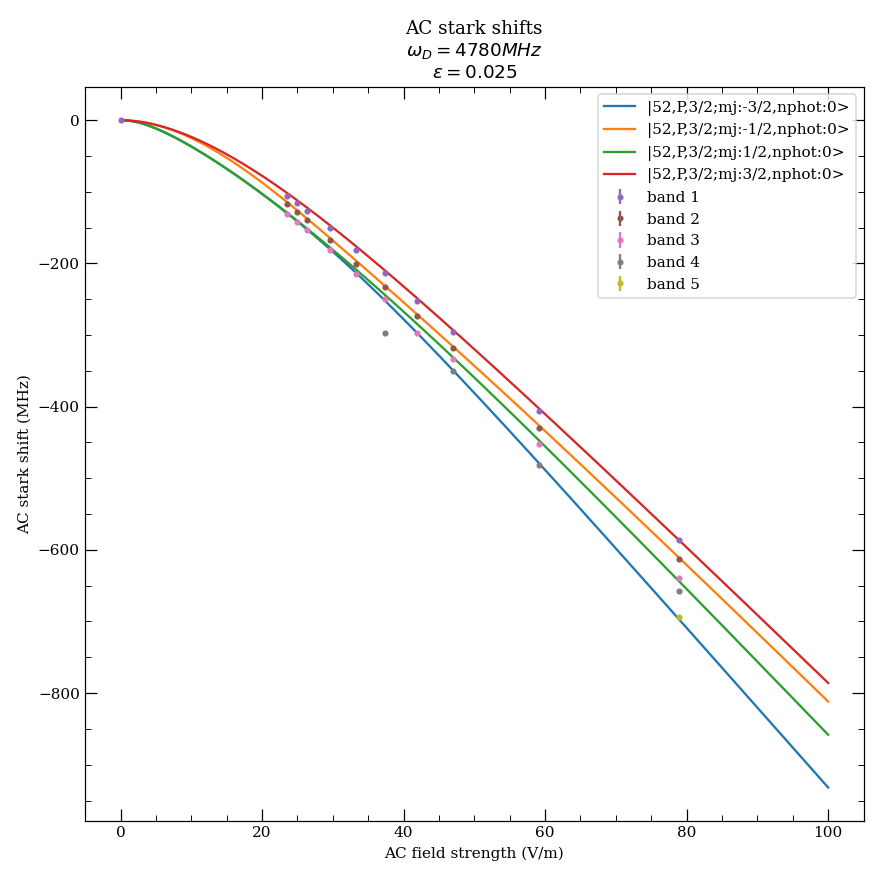

140
Levels :

[
	|52,S,1/2>,
	|52,P,1/2>,
	|52,P,3/2>,
	|51,D,3/2>,
	|51,D,5/2>,
	|53,S,1/2>
]
little_d built in 0.002991914749145508
Hdc built in 0.0
Hfloquet put together in 0.0009975433349609375
Floquet matrix built after 0.003989458084106445 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 0.0, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0019943714141845703s
Normalization Complete after 0.0019948482513427734 s
floquet_diag call completed in 0.007978677749633789s
Diagonalization complete for independent variable entry, value 0, 0.0
finding good eigenvectors for |level, n> = ||52,S,1/2>,-3>
finding good eigenvectors for |level, n> = ||52,S,1/2>,-2>
finding good eigenvectors for |level, n> = ||52,S,1/2>,-1>
finding good eigenvectors for |level, n> = ||52,S,1/2>,0>
finding good eigenvectors for |level, n> = ||52,S,1/2>,1>
finding good eigenvectors for |level, n> = ||52,S,1/2>,2>
finding 

C:\Users\Juan\Repos\two_photon_rydberg\floquet_hamiltonian.py:533: ComplexWarning: Casting complex values to real discards the imaginary part
  energies[inds[:, 1], i] = eigenvalues[inds[:, 0]]



floquet_diag call completed in 0.04883408546447754s
Diagonalization complete for independent variable entry, value 3, 0.3316582914572864
re-arrangement done after time 0.0029935836791992188s
little_d built in 0.0029892921447753906
Hdc built in 0.0
Hfloquet put together in 0.0009682178497314453
Floquet matrix built after 0.003957509994506836 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 0.44221105527638194, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04302406311035156s
Normalization Complete after 0.0019953250885009766 s
floquet_diag call completed in 0.048976898193359375s
Diagonalization complete for independent variable entry, value 4, 0.44221105527638194
re-arrangement done after time 0.0025653839111328125s
little_d built in 0.002991199493408203
Hdc built in 0.0
Hfloquet put together in 0.000997781753540039
Floquet matrix built after 0.003988981246948242 s
Begin Diagonalizing
Diago

Normalization Complete after 0.0019953250885009766 s
floquet_diag call completed in 0.049050331115722656s
Diagonalization complete for independent variable entry, value 19, 2.100502512562814
re-arrangement done after time 0.002959728240966797s
little_d built in 0.0030231475830078125
Hdc built in 0.000997304916381836
Hfloquet put together in 0.0
Floquet matrix built after 0.0040204524993896484 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 2.21105527638191, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04285311698913574s
Normalization Complete after 0.002027273178100586 s
floquet_diag call completed in 0.04890084266662598s
Diagonalization complete for independent variable entry, value 20, 2.21105527638191
re-arrangement done after time 0.002996683120727539s
little_d built in 0.002986431121826172
Hdc built in 0.0
Hfloquet put together in 0.0009984970092773438
Floquet matrix built after 0.0

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 3.869346733668342, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04383039474487305s
Normalization Complete after 0.0019943714141845703 s
floquet_diag call completed in 0.05077624320983887s
Diagonalization complete for independent variable entry, value 35, 3.869346733668342
re-arrangement done after time 0.00203704833984375s
little_d built in 0.0029969215393066406
Hdc built in 0.0009932518005371094
Hfloquet put together in 0.0
Floquet matrix built after 0.00399017333984375 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 3.9798994974874375, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0431973934173584s
Normalization Complete after 0.0020270347595214844 s
floquet_diag call completed in 0.04921460151672363s
Diagonalization complete for independent variable entry, value

Normalization Complete after 0.0019948482513427734 s
floquet_diag call completed in 0.04894590377807617s
Diagonalization complete for independent variable entry, value 51, 5.63819095477387
re-arrangement done after time 0.0029604434967041016s
little_d built in 0.0029916763305664062
Hdc built in 0.0
Hfloquet put together in 0.0009975433349609375
Floquet matrix built after 0.003989219665527344 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 5.748743718592965, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.042884111404418945s
Normalization Complete after 0.0020287036895751953 s
floquet_diag call completed in 0.048902034759521484s
Diagonalization complete for independent variable entry, value 52, 5.748743718592965
re-arrangement done after time 0.00199127197265625s
little_d built in 0.003988027572631836
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0039880275726318

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 7.407035175879398, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04431271553039551s
Normalization Complete after 0.00203704833984375 s
floquet_diag call completed in 0.050347089767456055s
Diagonalization complete for independent variable entry, value 67, 7.407035175879398
re-arrangement done after time 0.001996755599975586s
little_d built in 0.002989530563354492
Hdc built in 0.0010030269622802734
Hfloquet put together in 0.0
Floquet matrix built after 0.003992557525634766 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 7.517587939698493, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04304051399230957s
Normalization Complete after 0.001993417739868164 s
floquet_diag call completed in 0.0490264892578125s
Diagonalization complete for independent variable entry, value 6

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 9.175879396984925, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.042562007904052734s
Normalization Complete after 0.0019948482513427734 s
floquet_diag call completed in 0.04851078987121582s
Diagonalization complete for independent variable entry, value 83, 9.175879396984925
re-arrangement done after time 0.0029921531677246094s
little_d built in 0.002991914749145508
Hdc built in 0.0
Hfloquet put together in 0.0010538101196289062
Floquet matrix built after 0.004045724868774414 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 9.28643216080402, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04304170608520508s
Normalization Complete after 0.002027273178100586 s
floquet_diag call completed in 0.04911470413208008s
Diagonalization complete for independent variable entry, valu

Normalization Complete after 0.0030243396759033203 s
floquet_diag call completed in 0.04901528358459473s
Diagonalization complete for independent variable entry, value 99, 10.944723618090453
re-arrangement done after time 0.001963376998901367s
little_d built in 0.002991914749145508
Hdc built in 0.0
Hfloquet put together in 0.0009970664978027344
Floquet matrix built after 0.003988981246948242 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 11.055276381909549, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04288530349731445s
Normalization Complete after 0.0020263195037841797 s
floquet_diag call completed in 0.048900604248046875s
Diagonalization complete for independent variable entry, value 100, 11.055276381909549
re-arrangement done after time 0.0030031204223632812s
little_d built in 0.0029795169830322266
Hdc built in 0.0
Hfloquet put together in 0.001001596450805664
Floquet matrix built af

Normalization Complete after 0.0019481182098388672 s
floquet_diag call completed in 0.048267364501953125s
Diagonalization complete for independent variable entry, value 115, 12.713567839195981
re-arrangement done after time 0.00299072265625s
little_d built in 0.0029914379119873047
Hdc built in 0.0009989738464355469
Hfloquet put together in 0.0
Floquet matrix built after 0.0039904117584228516 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 12.824120603015077, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04288339614868164s
Normalization Complete after 0.0019958019256591797 s
floquet_diag call completed in 0.04886960983276367s
Diagonalization complete for independent variable entry, value 116, 12.824120603015077
re-arrangement done after time 0.0019927024841308594s
little_d built in 0.003023862838745117
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0040218830108

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 14.482412060301508, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04311871528625488s
Normalization Complete after 0.0030188560485839844 s
floquet_diag call completed in 0.04909634590148926s
Diagonalization complete for independent variable entry, value 131, 14.482412060301508
re-arrangement done after time 0.001992940902709961s
little_d built in 0.002992391586303711
Hdc built in 0.0009713172912597656
Hfloquet put together in 0.0
Floquet matrix built after 0.0039637088775634766 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 14.592964824120603, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04202556610107422s
Normalization Complete after 0.002029895782470703 s
floquet_diag call completed in 0.04901599884033203s
Diagonalization complete for independent variable entry, 

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 16.251256281407038, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04359078407287598s
Normalization Complete after 0.0019605159759521484 s
floquet_diag call completed in 0.049566030502319336s
Diagonalization complete for independent variable entry, value 147, 16.251256281407038
re-arrangement done after time 0.0030264854431152344s
little_d built in 0.003988027572631836
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003988027572631836 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 16.36180904522613, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.043183088302612305s
Normalization Complete after 0.0010364055633544922 s
floquet_diag call completed in 0.050200700759887695s
Diagonalization complete for independent variable entry, value 148, 16.3

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 18.020100502512562, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0428929328918457s
Normalization Complete after 0.0009999275207519531 s
floquet_diag call completed in 0.04888105392456055s
Diagonalization complete for independent variable entry, value 163, 18.020100502512562
re-arrangement done after time 0.002960205078125s
little_d built in 0.003032684326171875
Hdc built in 0.0
Hfloquet put together in 0.0009982585906982422
Floquet matrix built after 0.004030942916870117 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 18.13065326633166, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04331660270690918s
Normalization Complete after 0.0009975433349609375 s
floquet_diag call completed in 0.04934215545654297s
Diagonalization complete for independent variable entry, value

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 19.78894472361809, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04306626319885254s
Normalization Complete after 0.001992940902709961 s
floquet_diag call completed in 0.04905247688293457s
Diagonalization complete for independent variable entry, value 179, 19.78894472361809
re-arrangement done after time 0.0030264854431152344s
little_d built in 0.003952980041503906
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003952980041503906 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 19.899497487437188, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04390215873718262s
Normalization Complete after 0.0020360946655273438 s
floquet_diag call completed in 0.04989123344421387s
Diagonalization complete for independent variable entry, value 180, 19.899497

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 21.55778894472362, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04288172721862793s
Normalization Complete after 0.001992464065551758 s
floquet_diag call completed in 0.04886221885681152s
Diagonalization complete for independent variable entry, value 195, 21.55778894472362
re-arrangement done after time 0.0029926300048828125s
little_d built in 0.003026723861694336
Hdc built in 0.0
Hfloquet put together in 0.0009646415710449219
Floquet matrix built after 0.003991365432739258 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 21.668341708542716, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04305124282836914s
Normalization Complete after 0.0019953250885009766 s
floquet_diag call completed in 0.049037933349609375s
Diagonalization complete for independent variable entry, v

Normalization Complete after 0.0019974708557128906 s
floquet_diag call completed in 0.04851698875427246s
Diagonalization complete for independent variable entry, value 211, 26.415477386934672
re-arrangement done after time 0.0029897689819335938s
little_d built in 0.0029921531677246094
Hdc built in 0.0
Hfloquet put together in 0.0009648799896240234
Floquet matrix built after 0.003957033157348633 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 26.806884422110553, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.049866676330566406s
Normalization Complete after 0.0020313262939453125 s
floquet_diag call completed in 0.05585503578186035s
Diagonalization complete for independent variable entry, value 212, 26.806884422110553
re-arrangement done after time 0.0029878616333007812s
little_d built in 0.0029921531677246094
Hdc built in 0.0
Hfloquet put together in 0.0010111331939697266
Floquet matrix buil

Normalization Complete after 0.0020318031311035156 s
floquet_diag call completed in 0.04752969741821289s
Diagonalization complete for independent variable entry, value 227, 32.67798994974874
re-arrangement done after time 0.002955198287963867s
little_d built in 0.003025531768798828
Hdc built in 0.0010068416595458984
Hfloquet put together in 0.0
Floquet matrix built after 0.0040323734283447266 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 33.06939698492462, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04486846923828125s
Normalization Complete after 0.001995086669921875 s
floquet_diag call completed in 0.05089592933654785s
Diagonalization complete for independent variable entry, value 228, 33.06939698492462
re-arrangement done after time 0.0029926300048828125s
little_d built in 0.0029964447021484375
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.00299644470214

Normalization Complete after 0.0019617080688476562 s
floquet_diag call completed in 0.05084824562072754s
Diagonalization complete for independent variable entry, value 243, 38.940502512562816
re-arrangement done after time 0.0029938220977783203s
little_d built in 0.002991199493408203
Hdc built in 0.000997781753540039
Hfloquet put together in 0.0
Floquet matrix built after 0.003988981246948242 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 39.33190954773869, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.043599605560302734s
Normalization Complete after 0.002035856246948242 s
floquet_diag call completed in 0.04962444305419922s
Diagonalization complete for independent variable entry, value 244, 39.33190954773869
re-arrangement done after time 0.0029921531677246094s
little_d built in 0.002993345260620117
Hdc built in 0.0
Hfloquet put together in 0.000993490219116211
Floquet matrix built after

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 45.20301507537688, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04238152503967285s
Normalization Complete after 0.0020029544830322266 s
floquet_diag call completed in 0.04840707778930664s
Diagonalization complete for independent variable entry, value 259, 45.20301507537688
re-arrangement done after time 0.003957271575927734s
little_d built in 0.0030236244201660156
Hdc built in 0.0
Hfloquet put together in 0.0009953975677490234
Floquet matrix built after 0.004019021987915039 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 45.59442211055276, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04240155220031738s
Normalization Complete after 0.002029895782470703 s
floquet_diag call completed in 0.048450469970703125s
Diagonalization complete for independent variable entry, va

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 51.46552763819095, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04333090782165527s
Normalization Complete after 0.0019898414611816406 s
floquet_diag call completed in 0.04930424690246582s
Diagonalization complete for independent variable entry, value 275, 51.46552763819095
re-arrangement done after time 0.0029914379119873047s
little_d built in 0.004022836685180664
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.004022836685180664 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 51.85693467336684, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04380917549133301s
Normalization Complete after 0.001994609832763672 s
floquet_diag call completed in 0.049826622009277344s
Diagonalization complete for independent variable entry, value 276, 51.856934

Normalization Complete after 0.0019948482513427734 s
floquet_diag call completed in 0.048870086669921875s
Diagonalization complete for independent variable entry, value 291, 57.72804020100502
re-arrangement done after time 0.003023386001586914s
little_d built in 0.002992391586303711
Hdc built in 0.0
Hfloquet put together in 0.0010073184967041016
Floquet matrix built after 0.0039997100830078125 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 58.1194472361809, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.044092655181884766s
Normalization Complete after 0.0009982585906982422 s
floquet_diag call completed in 0.050125837326049805s
Diagonalization complete for independent variable entry, value 292, 58.1194472361809
re-arrangement done after time 0.0029990673065185547s
little_d built in 0.002992868423461914
Hdc built in 0.0009951591491699219
Hfloquet put together in 0.0
Floquet matrix built aft

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 63.990552763819096, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.044643402099609375s
Normalization Complete after 0.001964092254638672 s
floquet_diag call completed in 0.05058693885803223s
Diagonalization complete for independent variable entry, value 307, 63.990552763819096
re-arrangement done after time 0.002989053726196289s
little_d built in 0.0030243396759033203
Hdc built in 0.0
Hfloquet put together in 0.0009989738464355469
Floquet matrix built after 0.004023313522338867 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 64.38195979899497, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04433298110961914s
Normalization Complete after 0.0020384788513183594 s
floquet_diag call completed in 0.05039477348327637s
Diagonalization complete for independent variable entry, 

Normalization Complete after 0.0019953250885009766 s
floquet_diag call completed in 0.049048662185668945s
Diagonalization complete for independent variable entry, value 323, 70.25306532663316
re-arrangement done after time 0.0029959678649902344s
little_d built in 0.003983497619628906
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003983497619628906 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 70.64447236180905, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0438847541809082s
Normalization Complete after 0.0019960403442382812 s
floquet_diag call completed in 0.04986429214477539s
Diagonalization complete for independent variable entry, value 324, 70.64447236180905
re-arrangement done after time 0.001990795135498047s
little_d built in 0.0029914379119873047
Hdc built in 0.0
Hfloquet put together in 0.0009996891021728516
Floquet matrix built after 0.00399112701416

Normalization Complete after 0.001996755599975586 s
floquet_diag call completed in 0.05118751525878906s
Diagonalization complete for independent variable entry, value 339, 76.51557788944723
re-arrangement done after time 0.0029926300048828125s
little_d built in 0.003026247024536133
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.004021644592285156 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 76.90698492462312, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04484724998474121s
Normalization Complete after 0.0010302066802978516 s
floquet_diag call completed in 0.05089855194091797s
Diagonalization complete for independent variable entry, value 340, 76.90698492462312
re-arrangement done after time 0.001993417739868164s
little_d built in 0.001992464065551758
Hdc built in 0.0010004043579101562
Hfloquet put together in 0.0
Floquet matrix built after 0.0029928684234619

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 82.7780904522613, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04413247108459473s
Normalization Complete after 0.002033710479736328 s
floquet_diag call completed in 0.05015683174133301s
Diagonalization complete for independent variable entry, value 355, 82.7780904522613
re-arrangement done after time 0.002996206283569336s
little_d built in 0.0029888153076171875
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003986358642578125 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 83.16949748743718, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04323124885559082s
Normalization Complete after 0.001989603042602539 s
floquet_diag call completed in 0.049207210540771484s
Diagonalization complete for independent variable entry, value 356, 83.169497487

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 89.04060301507538, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04463934898376465s
Normalization Complete after 0.0019936561584472656 s
floquet_diag call completed in 0.050656795501708984s
Diagonalization complete for independent variable entry, value 371, 89.04060301507538
re-arrangement done after time 0.0029926300048828125s
little_d built in 0.0030248165130615234
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0030248165130615234 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 89.43201005025125, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.045575618743896484s
Normalization Complete after 0.0020275115966796875 s
floquet_diag call completed in 0.050627946853637695s
Diagonalization complete for independent variable entry, value 372, 89.4

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 95.30311557788944, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.045012474060058594s
Normalization Complete after 0.003027677536010742 s
floquet_diag call completed in 0.05202937126159668s
Diagonalization complete for independent variable entry, value 387, 95.30311557788944
re-arrangement done after time 0.0029888153076171875s
little_d built in 0.0029611587524414062
Hdc built in 0.0009965896606445312
Hfloquet put together in 0.0
Floquet matrix built after 0.0039577484130859375 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 95.69452261306532, ellipticity 0.03, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.045046329498291016s
Normalization Complete after 0.002027750015258789 s
floquet_diag call completed in 0.05103182792663574s
Diagonalization complete for independent variable entry, 

<IPython.core.display.Javascript object>


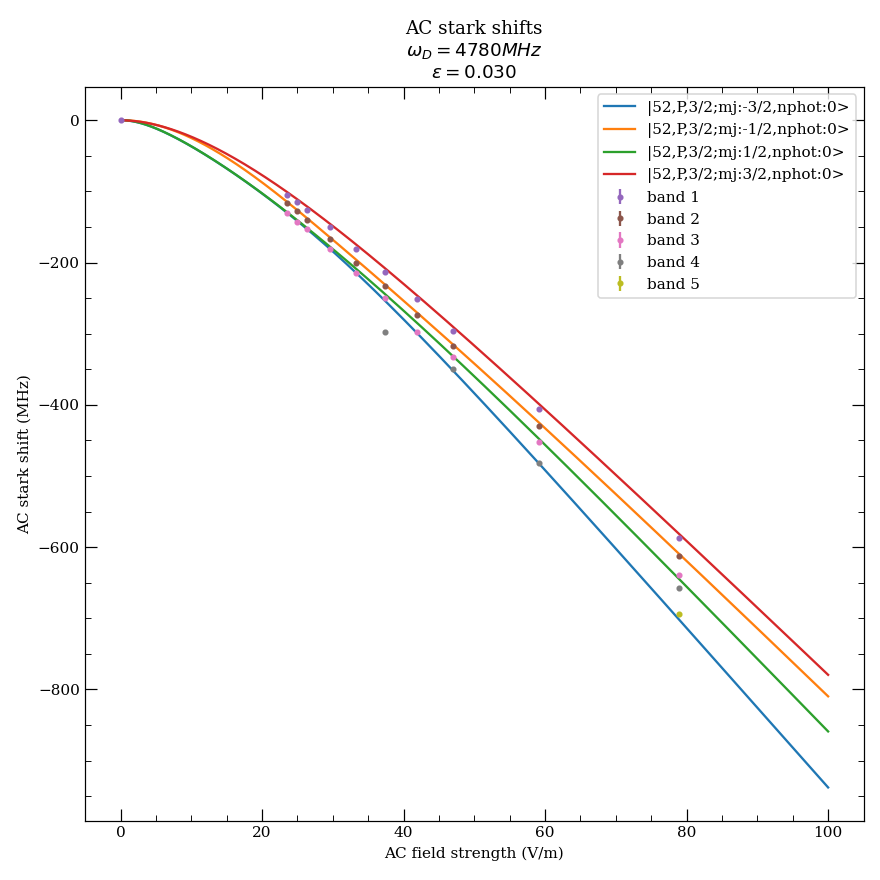

140
Levels :

[
	|52,S,1/2>,
	|52,P,1/2>,
	|52,P,3/2>,
	|51,D,3/2>,
	|51,D,5/2>,
	|53,S,1/2>
]
little_d built in 0.0029921531677246094
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0029921531677246094 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 0.0, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0029592514038085938s
Normalization Complete after 0.0020389556884765625 s
floquet_diag call completed in 0.007990360260009766s
Diagonalization complete for independent variable entry, value 0, 0.0
finding good eigenvectors for |level, n> = ||52,S,1/2>,-3>
finding good eigenvectors for |level, n> = ||52,S,1/2>,-2>
finding good eigenvectors for |level, n> = ||52,S,1/2>,-1>
finding good eigenvectors for |level, n> = ||52,S,1/2>,0>
finding good eigenvectors for |level, n> = ||52,S,1/2>,1>
finding good eigenvectors for |level, n> = ||52,S,1/2>,2>
finding good eigenvecto

C:\Users\Juan\Repos\two_photon_rydberg\floquet_hamiltonian.py:533: ComplexWarning: Casting complex values to real discards the imaginary part
  energies[inds[:, 1], i] = eigenvalues[inds[:, 0]]


Diagonalized after time: 0.04234790802001953s
Normalization Complete after 0.0020294189453125 s
floquet_diag call completed in 0.04736924171447754s
Diagonalization complete for independent variable entry, value 3, 0.3316582914572864
re-arrangement done after time 0.003000974655151367s
little_d built in 0.002985239028930664
Hdc built in 0.0009949207305908203
Hfloquet put together in 0.0
Floquet matrix built after 0.003980159759521484 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 0.44221105527638194, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.044034481048583984s
Normalization Complete after 0.002029895782470703 s
floquet_diag call completed in 0.05004453659057617s
Diagonalization complete for independent variable entry, value 4, 0.44221105527638194
re-arrangement done after time 0.00299072265625s
little_d built in 0.0029897689819335938
Hdc built in 0.0
Hfloquet put together in 0.00100

Normalization Complete after 0.001962423324584961 s
floquet_diag call completed in 0.04842782020568848s
Diagonalization complete for independent variable entry, value 19, 2.100502512562814
re-arrangement done after time 0.003989696502685547s
little_d built in 0.003033161163330078
Hdc built in 0.0
Hfloquet put together in 0.0009551048278808594
Floquet matrix built after 0.0039882659912109375 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 2.21105527638191, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04309558868408203s
Normalization Complete after 0.001995086669921875 s
floquet_diag call completed in 0.05007815361022949s
Diagonalization complete for independent variable entry, value 20, 2.21105527638191
re-arrangement done after time 0.00299835205078125s
little_d built in 0.0029866695404052734
Hdc built in 0.0
Hfloquet put together in 0.0009942054748535156
Floquet matrix built after 0.00

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 3.869346733668342, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04381608963012695s
Normalization Complete after 0.0009622573852539062 s
floquet_diag call completed in 0.04980015754699707s
Diagonalization complete for independent variable entry, value 35, 3.869346733668342
re-arrangement done after time 0.0019943714141845703s
little_d built in 0.0029523372650146484
Hdc built in 0.0
Hfloquet put together in 0.0009951591491699219
Floquet matrix built after 0.00394749641418457 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 3.9798994974874375, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04267072677612305s
Normalization Complete after 0.0020294189453125 s
floquet_diag call completed in 0.04864764213562012s
Diagonalization complete for independent variable entry, val

Normalization Complete after 0.002029895782470703 s
floquet_diag call completed in 0.049432992935180664s
Diagonalization complete for independent variable entry, value 51, 5.63819095477387
re-arrangement done after time 0.0029935836791992188s
little_d built in 0.002991199493408203
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.00398707389831543 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 5.748743718592965, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04285144805908203s
Normalization Complete after 0.0020270347595214844 s
floquet_diag call completed in 0.048865556716918945s
Diagonalization complete for independent variable entry, value 52, 5.748743718592965
re-arrangement done after time 0.0029916763305664062s
little_d built in 0.0029914379119873047
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003989219665527344 s
Begin Diagon

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 7.407035175879398, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04393720626831055s
Normalization Complete after 0.0020270347595214844 s
floquet_diag call completed in 0.04895520210266113s
Diagonalization complete for independent variable entry, value 67, 7.407035175879398
re-arrangement done after time 0.002993345260620117s
little_d built in 0.002992868423461914
Hdc built in 0.0
Hfloquet put together in 0.0009980201721191406
Floquet matrix built after 0.003990888595581055 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 7.517587939698493, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.043802499771118164s
Normalization Complete after 0.001991748809814453 s
floquet_diag call completed in 0.04978513717651367s
Diagonalization complete for independent variable entry, va

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 9.175879396984925, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04383087158203125s
Normalization Complete after 0.0019865036010742188 s
floquet_diag call completed in 0.05081772804260254s
Diagonalization complete for independent variable entry, value 83, 9.175879396984925
re-arrangement done after time 0.0019893646240234375s
little_d built in 0.0029909610748291016
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003987312316894531 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 9.28643216080402, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.044228553771972656s
Normalization Complete after 0.0020003318786621094 s
floquet_diag call completed in 0.05121493339538574s
Diagonalization complete for independent variable entry, value 84, 9.286432

Normalization Complete after 0.0020275115966796875 s
floquet_diag call completed in 0.04861617088317871s
Diagonalization complete for independent variable entry, value 99, 10.944723618090453
re-arrangement done after time 0.003957509994506836s
little_d built in 0.004985809326171875
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.004985809326171875 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 11.055276381909549, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04288744926452637s
Normalization Complete after 0.001995086669921875 s
floquet_diag call completed in 0.04986834526062012s
Diagonalization complete for independent variable entry, value 100, 11.055276381909549
re-arrangement done after time 0.002990245819091797s
little_d built in 0.0030286312103271484
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0030286312103271484 s
Begin Dia

Normalization Complete after 0.0019617080688476562 s
floquet_diag call completed in 0.04904484748840332s
Diagonalization complete for independent variable entry, value 115, 12.713567839195981
re-arrangement done after time 0.0019958019256591797s
little_d built in 0.0029916763305664062
Hdc built in 0.0
Hfloquet put together in 0.0010340213775634766
Floquet matrix built after 0.004025697708129883 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 12.824120603015077, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.042882442474365234s
Normalization Complete after 0.0009634494781494141 s
floquet_diag call completed in 0.04886770248413086s
Diagonalization complete for independent variable entry, value 116, 12.824120603015077
re-arrangement done after time 0.0019953250885009766s
little_d built in 0.0030274391174316406
Hdc built in 0.0
Hfloquet put together in 0.0009617805480957031
Floquet matrix bui

Normalization Complete after 0.001997232437133789 s
floquet_diag call completed in 0.04925704002380371s
Diagonalization complete for independent variable entry, value 131, 14.482412060301508
re-arrangement done after time 0.0019953250885009766s
little_d built in 0.0029909610748291016
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0029909610748291016 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 14.592964824120603, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.043123483657836914s
Normalization Complete after 0.001981496810913086 s
floquet_diag call completed in 0.0480959415435791s
Diagonalization complete for independent variable entry, value 132, 14.592964824120603
re-arrangement done after time 0.0020034313201904297s
little_d built in 0.0029914379119873047
Hdc built in 0.0
Hfloquet put together in 0.0009989738464355469
Floquet matrix built after 0.003990411

Normalization Complete after 0.0019941329956054688 s
floquet_diag call completed in 0.04981684684753418s
Diagonalization complete for independent variable entry, value 147, 16.251256281407038
re-arrangement done after time 0.0020058155059814453s
little_d built in 0.002991914749145508
Hdc built in 0.0
Hfloquet put together in 0.0009970664978027344
Floquet matrix built after 0.003988981246948242 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 16.36180904522613, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04185342788696289s
Normalization Complete after 0.0020296573638916016 s
floquet_diag call completed in 0.048866987228393555s
Diagonalization complete for independent variable entry, value 148, 16.36180904522613
re-arrangement done after time 0.001997232437133789s
little_d built in 0.0029909610748291016
Hdc built in 0.0
Hfloquet put together in 0.0009999275207519531
Floquet matrix built a

Normalization Complete after 0.0019941329956054688 s
floquet_diag call completed in 0.048038482666015625s
Diagonalization complete for independent variable entry, value 163, 18.020100502512562
re-arrangement done after time 0.001995086669921875s
little_d built in 0.0019953250885009766
Hdc built in 0.0010161399841308594
Hfloquet put together in 0.0
Floquet matrix built after 0.003011465072631836 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 18.13065326633166, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04482865333557129s
Normalization Complete after 0.0020313262939453125 s
floquet_diag call completed in 0.05089998245239258s
Diagonalization complete for independent variable entry, value 164, 18.13065326633166
re-arrangement done after time 0.0029878616333007812s
little_d built in 0.002991199493408203
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.00299119949

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 19.78894472361809, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04299306869506836s
Normalization Complete after 0.0030260086059570312 s
floquet_diag call completed in 0.049045562744140625s
Diagonalization complete for independent variable entry, value 179, 19.78894472361809
re-arrangement done after time 0.001992940902709961s
little_d built in 0.002992391586303711
Hdc built in 0.0010037422180175781
Hfloquet put together in 0.0
Floquet matrix built after 0.003996133804321289 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 19.899497487437188, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.043843984603881836s
Normalization Complete after 0.002035379409790039 s
floquet_diag call completed in 0.049875497817993164s
Diagonalization complete for independent variable entry

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 21.55778894472362, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04302787780761719s
Normalization Complete after 0.002030611038208008 s
floquet_diag call completed in 0.04905414581298828s
Diagonalization complete for independent variable entry, value 195, 21.55778894472362
re-arrangement done after time 0.002985239028930664s
little_d built in 0.0029931068420410156
Hdc built in 0.0
Hfloquet put together in 0.0009632110595703125
Floquet matrix built after 0.003956317901611328 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 21.668341708542716, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04207348823547363s
Normalization Complete after 0.0030269622802734375 s
floquet_diag call completed in 0.0490567684173584s
Diagonalization complete for independent variable entry, v

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 26.415477386934672, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04264235496520996s
Normalization Complete after 0.001993417739868164 s
floquet_diag call completed in 0.04862618446350098s
Diagonalization complete for independent variable entry, value 211, 26.415477386934672
re-arrangement done after time 0.0030248165130615234s
little_d built in 0.0029594898223876953
Hdc built in 0.0
Hfloquet put together in 0.0010352134704589844
Floquet matrix built after 0.00399470329284668 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 26.806884422110553, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04338979721069336s
Normalization Complete after 0.0020287036895751953 s
floquet_diag call completed in 0.049413204193115234s
Diagonalization complete for independent variable entr

Normalization Complete after 0.0019965171813964844 s
floquet_diag call completed in 0.04823470115661621s
Diagonalization complete for independent variable entry, value 227, 32.67798994974874
re-arrangement done after time 0.0029566287994384766s
little_d built in 0.003990888595581055
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003990888595581055 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 33.06939698492462, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.045439958572387695s
Normalization Complete after 0.00203704833984375 s
floquet_diag call completed in 0.05246782302856445s
Diagonalization complete for independent variable entry, value 228, 33.06939698492462
re-arrangement done after time 0.001992464065551758s
little_d built in 0.003989696502685547
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003989696502685547 s
Begin Diagon

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 38.940502512562816, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04300427436828613s
Normalization Complete after 0.0019943714141845703 s
floquet_diag call completed in 0.04799079895019531s
Diagonalization complete for independent variable entry, value 243, 38.940502512562816
re-arrangement done after time 0.002994537353515625s
little_d built in 0.0029900074005126953
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0029900074005126953 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 39.33190954773869, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04378175735473633s
Normalization Complete after 0.0020329952239990234 s
floquet_diag call completed in 0.04880475997924805s
Diagonalization complete for independent variable entry, value 244, 39.3

Normalization Complete after 0.0019974708557128906 s
floquet_diag call completed in 0.0500943660736084s
Diagonalization complete for independent variable entry, value 259, 45.20301507537688
re-arrangement done after time 0.0019609928131103516s
little_d built in 0.00299072265625
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.00299072265625 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 45.59442211055276, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.045844316482543945s
Normalization Complete after 0.0020294189453125 s
floquet_diag call completed in 0.051859378814697266s
Diagonalization complete for independent variable entry, value 260, 45.59442211055276
re-arrangement done after time 0.001993894577026367s
little_d built in 0.0029916763305664062
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003991365432739258 s
Begin Diagonalizing


Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 51.46552763819095, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04349398612976074s
Normalization Complete after 0.002992391586303711 s
floquet_diag call completed in 0.050443410873413086s
Diagonalization complete for independent variable entry, value 275, 51.46552763819095
re-arrangement done after time 0.0029916763305664062s
little_d built in 0.0029926300048828125
Hdc built in 0.0
Hfloquet put together in 0.0010590553283691406
Floquet matrix built after 0.004051685333251953 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 51.85693467336684, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04404807090759277s
Normalization Complete after 0.001997709274291992 s
floquet_diag call completed in 0.050977230072021484s
Diagonalization complete for independent variable entry,

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 57.72804020100502, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.044625043869018555s
Normalization Complete after 0.0019965171813964844 s
floquet_diag call completed in 0.05057573318481445s
Diagonalization complete for independent variable entry, value 291, 57.72804020100502
re-arrangement done after time 0.0029900074005126953s
little_d built in 0.002991199493408203
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0039899349212646484 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 58.1194472361809, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04502701759338379s
Normalization Complete after 0.00196075439453125 s
floquet_diag call completed in 0.05097770690917969s
Diagonalization complete for independent variable entry, value 292, 58.11944

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 63.990552763819096, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04509544372558594s
Normalization Complete after 0.0019931793212890625 s
floquet_diag call completed in 0.05008077621459961s
Diagonalization complete for independent variable entry, value 307, 63.990552763819096
re-arrangement done after time 0.0030341148376464844s
little_d built in 0.0029947757720947266
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.00394749641418457 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 64.38195979899497, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04349064826965332s
Normalization Complete after 0.0019927024841308594 s
floquet_diag call completed in 0.04943084716796875s
Diagonalization complete for independent variable entry, value 308, 64.38

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 70.25306532663316, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04261612892150879s
Normalization Complete after 0.0019927024841308594 s
floquet_diag call completed in 0.04963254928588867s
Diagonalization complete for independent variable entry, value 323, 70.25306532663316
re-arrangement done after time 0.0029921531677246094s
little_d built in 0.002960681915283203
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.002960681915283203 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 70.64447236180905, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04497051239013672s
Normalization Complete after 0.002028942108154297 s
floquet_diag call completed in 0.04996013641357422s
Diagonalization complete for independent variable entry, value 324, 70.64447

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 76.51557788944723, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04614543914794922s
Normalization Complete after 0.0019958019256591797 s
floquet_diag call completed in 0.05113339424133301s
Diagonalization complete for independent variable entry, value 339, 76.51557788944723
re-arrangement done after time 0.001992464065551758s
little_d built in 0.0029909610748291016
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0029909610748291016 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 76.90698492462312, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.044071197509765625s
Normalization Complete after 0.0009865760803222656 s
floquet_diag call completed in 0.05105471611022949s
Diagonalization complete for independent variable entry, value 340, 76.90

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 82.7780904522613, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04486370086669922s
Normalization Complete after 0.001994609832763672 s
floquet_diag call completed in 0.05084800720214844s
Diagonalization complete for independent variable entry, value 355, 82.7780904522613
re-arrangement done after time 0.002991199493408203s
little_d built in 0.0030260086059570312
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.004021167755126953 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 83.16949748743718, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04398322105407715s
Normalization Complete after 0.0020248889923095703 s
floquet_diag call completed in 0.05102896690368652s
Diagonalization complete for independent variable entry, value 356, 83.1694974

Normalization Complete after 0.0019943714141845703 s
floquet_diag call completed in 0.04999065399169922s
Diagonalization complete for independent variable entry, value 371, 89.04060301507538
re-arrangement done after time 0.003025531768798828s
little_d built in 0.0029931068420410156
Hdc built in 0.0009987354278564453
Hfloquet put together in 0.0
Floquet matrix built after 0.003991842269897461 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 89.43201005025125, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04571127891540527s
Normalization Complete after 0.001992940902709961 s
floquet_diag call completed in 0.051696062088012695s
Diagonalization complete for independent variable entry, value 372, 89.43201005025125
re-arrangement done after time 0.0029916763305664062s
little_d built in 0.002991914749145508
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0039894580841

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 95.30311557788944, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.044284820556640625s
Normalization Complete after 0.002028942108154297 s
floquet_diag call completed in 0.05030322074890137s
Diagonalization complete for independent variable entry, value 387, 95.30311557788944
re-arrangement done after time 0.0029904842376708984s
little_d built in 0.003000020980834961
Hdc built in 0.0
Hfloquet put together in 0.0009620189666748047
Floquet matrix built after 0.003962039947509766 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 95.69452261306532, ellipticity 0.035, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04416537284851074s
Normalization Complete after 0.0019922256469726562 s
floquet_diag call completed in 0.0511167049407959s
Diagonalization complete for independent variable entry, v

<IPython.core.display.Javascript object>


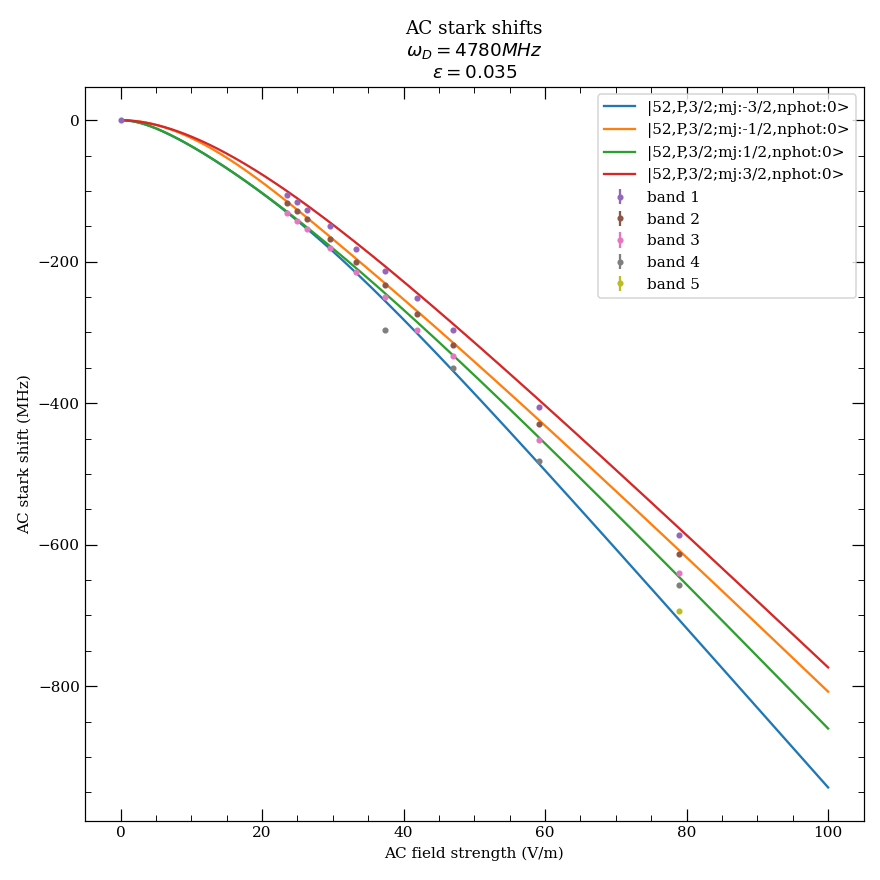

140
Levels :

[
	|52,S,1/2>,
	|52,P,1/2>,
	|52,P,3/2>,
	|51,D,3/2>,
	|51,D,5/2>,
	|53,S,1/2>
]
little_d built in 0.002992391586303711
Hdc built in 0.0009903907775878906
Hfloquet put together in 0.0
Floquet matrix built after 0.0039827823638916016 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 0.0, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0029592514038085938s
Normalization Complete after 0.0020279884338378906 s
floquet_diag call completed in 0.008970022201538086s
Diagonalization complete for independent variable entry, value 0, 0.0
finding good eigenvectors for |level, n> = ||52,S,1/2>,-3>
finding good eigenvectors for |level, n> = ||52,S,1/2>,-2>
finding good eigenvectors for |level, n> = ||52,S,1/2>,-1>
finding good eigenvectors for |level, n> = ||52,S,1/2>,0>
finding good eigenvectors for |level, n> = ||52,S,1/2>,1>
finding good eigenvectors for |level, n> = ||52,S,1/2>,2>
finding

C:\Users\Juan\Repos\two_photon_rydberg\floquet_hamiltonian.py:533: ComplexWarning: Casting complex values to real discards the imaginary part
  energies[inds[:, 1], i] = eigenvalues[inds[:, 0]]


Normalization Complete after 0.0019919872283935547 s
floquet_diag call completed in 0.049945831298828125s
Diagonalization complete for independent variable entry, value 3, 0.3316582914572864
re-arrangement done after time 0.0030260086059570312s
little_d built in 0.0029582977294921875
Hdc built in 0.0
Hfloquet put together in 0.0009975433349609375
Floquet matrix built after 0.003955841064453125 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 0.44221105527638194, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04188847541809082s
Normalization Complete after 0.001993894577026367 s
floquet_diag call completed in 0.04783821105957031s
Diagonalization complete for independent variable entry, value 4, 0.44221105527638194
re-arrangement done after time 0.0029921531677246094s
little_d built in 0.0029916763305664062
Hdc built in 0.000997304916381836
Hfloquet put together in 0.0
Floquet matrix built af

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 2.100502512562814, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.042745113372802734s
Normalization Complete after 0.0029916763305664062 s
floquet_diag call completed in 0.048760414123535156s
Diagonalization complete for independent variable entry, value 19, 2.100502512562814
re-arrangement done after time 0.0029914379119873047s
little_d built in 0.002991914749145508
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0039904117584228516 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 2.21105527638191, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04214882850646973s
Normalization Complete after 0.0020055770874023438 s
floquet_diag call completed in 0.04814481735229492s
Diagonalization complete for independent variable entry, value 20, 2.2110552

Normalization Complete after 0.0019936561584472656 s
floquet_diag call completed in 0.049558401107788086s
Diagonalization complete for independent variable entry, value 35, 3.869346733668342
re-arrangement done after time 0.002958536148071289s
little_d built in 0.003989458084106445
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003989458084106445 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 3.9798994974874375, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04288530349731445s
Normalization Complete after 0.0019965171813964844 s
floquet_diag call completed in 0.04986882209777832s
Diagonalization complete for independent variable entry, value 36, 3.9798994974874375
re-arrangement done after time 0.0020258426666259766s
little_d built in 0.001990795135498047
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.002990245819091797 s
Begin Diago

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 5.63819095477387, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0426790714263916s
Normalization Complete after 0.002028226852416992 s
floquet_diag call completed in 0.04866313934326172s
Diagonalization complete for independent variable entry, value 51, 5.63819095477387
re-arrangement done after time 0.0030040740966796875s
little_d built in 0.003993034362792969
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003993034362792969 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 5.748743718592965, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04283595085144043s
Normalization Complete after 0.001994609832763672 s
floquet_diag call completed in 0.04882359504699707s
Diagonalization complete for independent variable entry, value 52, 5.74874371859296

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 7.407035175879398, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04445910453796387s
Normalization Complete after 0.0019953250885009766 s
floquet_diag call completed in 0.05044150352478027s
Diagonalization complete for independent variable entry, value 67, 7.407035175879398
re-arrangement done after time 0.00299072265625s
little_d built in 0.0030286312103271484
Hdc built in 0.0
Hfloquet put together in 0.0009632110595703125
Floquet matrix built after 0.003991842269897461 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 7.517587939698493, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.044026851654052734s
Normalization Complete after 0.000997781753540039 s
floquet_diag call completed in 0.05001235008239746s
Diagonalization complete for independent variable entry, value 6

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 9.175879396984925, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04382896423339844s
Normalization Complete after 0.002026796340942383 s
floquet_diag call completed in 0.04985213279724121s
Diagonalization complete for independent variable entry, value 83, 9.175879396984925
re-arrangement done after time 0.0030014514923095703s
little_d built in 0.002992391586303711
Hdc built in 0.0
Hfloquet put together in 0.00099945068359375
Floquet matrix built after 0.003991842269897461 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 9.28643216080402, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04281783103942871s
Normalization Complete after 0.0019943714141845703 s
floquet_diag call completed in 0.04880404472351074s
Diagonalization complete for independent variable entry, value 8

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 10.944723618090453, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04150652885437012s
Normalization Complete after 0.003023386001586914 s
floquet_diag call completed in 0.04851651191711426s
Diagonalization complete for independent variable entry, value 99, 10.944723618090453
re-arrangement done after time 0.002960205078125s
little_d built in 0.003023386001586914
Hdc built in 0.0
Hfloquet put together in 0.0010073184967041016
Floquet matrix built after 0.004030704498291016 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 11.055276381909549, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.043192148208618164s
Normalization Complete after 0.001993894577026367 s
floquet_diag call completed in 0.04921674728393555s
Diagonalization complete for independent variable entry, value

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 12.713567839195981, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04285264015197754s
Normalization Complete after 0.0009958744049072266 s
floquet_diag call completed in 0.04881167411804199s
Diagonalization complete for independent variable entry, value 115, 12.713567839195981
re-arrangement done after time 0.0029981136322021484s
little_d built in 0.0029861927032470703
Hdc built in 0.0
Hfloquet put together in 0.0009953975677490234
Floquet matrix built after 0.003981590270996094 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 12.824120603015077, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0413515567779541s
Normalization Complete after 0.0020372867584228516 s
floquet_diag call completed in 0.04836702346801758s
Diagonalization complete for independent variable entry,

Normalization Complete after 0.002030611038208008 s
floquet_diag call completed in 0.0481410026550293s
Diagonalization complete for independent variable entry, value 131, 14.482412060301508
re-arrangement done after time 0.002958059310913086s
little_d built in 0.003989219665527344
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003989219665527344 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 14.592964824120603, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.042883872985839844s
Normalization Complete after 0.0020270347595214844 s
floquet_diag call completed in 0.04890012741088867s
Diagonalization complete for independent variable entry, value 132, 14.592964824120603
re-arrangement done after time 0.0019960403442382812s
little_d built in 0.0030019283294677734
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0030019283294677734 s
Begin Di

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 16.251256281407038, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.043627262115478516s
Normalization Complete after 0.002011537551879883 s
floquet_diag call completed in 0.04963421821594238s
Diagonalization complete for independent variable entry, value 147, 16.251256281407038
re-arrangement done after time 0.0029914379119873047s
little_d built in 0.0029611587524414062
Hdc built in 0.0010347366333007812
Hfloquet put together in 0.0
Floquet matrix built after 0.0039958953857421875 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 16.36180904522613, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04210066795349121s
Normalization Complete after 0.002033233642578125 s
floquet_diag call completed in 0.04812979698181152s
Diagonalization complete for independent variable entry,

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 18.020100502512562, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04243326187133789s
Normalization Complete after 0.002027273178100586 s
floquet_diag call completed in 0.04844832420349121s
Diagonalization complete for independent variable entry, value 163, 18.020100502512562
re-arrangement done after time 0.0029931068420410156s
little_d built in 0.0029952526092529297
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003987789154052734 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 18.13065326633166, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.043904781341552734s
Normalization Complete after 0.002017974853515625 s
floquet_diag call completed in 0.049910545349121094s
Diagonalization complete for independent variable entry, value 164, 18.130

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 19.78894472361809, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04325103759765625s
Normalization Complete after 0.001995563507080078 s
floquet_diag call completed in 0.04922986030578613s
Diagonalization complete for independent variable entry, value 179, 19.78894472361809
re-arrangement done after time 0.002992391586303711s
little_d built in 0.0039899349212646484
Hdc built in 0.0
Hfloquet put together in 0.000997781753540039
Floquet matrix built after 0.0049877166748046875 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 19.899497487437188, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.042320966720581055s
Normalization Complete after 0.0019948482513427734 s
floquet_diag call completed in 0.049303531646728516s
Diagonalization complete for independent variable entry, 

re-arrangement done after time 0.003027677536010742s
little_d built in 0.0029573440551757812
Hdc built in 0.0
Hfloquet put together in 0.0009968280792236328
Floquet matrix built after 0.003954172134399414 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 21.668341708542716, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.043915510177612305s
Normalization Complete after 0.001961946487426758 s
floquet_diag call completed in 0.04983162879943848s
Diagonalization complete for independent variable entry, value 196, 21.668341708542716
re-arrangement done after time 0.002992391586303711s
little_d built in 0.0029916763305664062
Hdc built in 0.0
Hfloquet put together in 0.0009975433349609375
Floquet matrix built after 0.003989219665527344 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 21.77889447236181, ellipticity 0.04, field_omega 30033625768.31842
DC parameter

Normalization Complete after 0.0019948482513427734 s
floquet_diag call completed in 0.0482640266418457s
Diagonalization complete for independent variable entry, value 211, 26.415477386934672
re-arrangement done after time 0.0029914379119873047s
little_d built in 0.0029921531677246094
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003992319107055664 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 26.806884422110553, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.043882131576538086s
Normalization Complete after 0.001985311508178711 s
floquet_diag call completed in 0.04985976219177246s
Diagonalization complete for independent variable entry, value 212, 26.806884422110553
re-arrangement done after time 0.0030002593994140625s
little_d built in 0.0029921531677246094
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0029921531677246094 s
Begin 

Normalization Complete after 0.0030248165130615234 s
floquet_diag call completed in 0.049658775329589844s
Diagonalization complete for independent variable entry, value 227, 32.67798994974874
re-arrangement done after time 0.001963376998901367s
little_d built in 0.001998424530029297
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0029942989349365234 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 33.06939698492462, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04285025596618652s
Normalization Complete after 0.002027273178100586 s
floquet_diag call completed in 0.04787182807922363s
Diagonalization complete for independent variable entry, value 228, 33.06939698492462
re-arrangement done after time 0.002994060516357422s
little_d built in 0.003989458084106445
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003989458084106445 s
Begin Diagon

Normalization Complete after 0.0019958019256591797 s
floquet_diag call completed in 0.04928898811340332s
Diagonalization complete for independent variable entry, value 243, 38.940502512562816
re-arrangement done after time 0.001993894577026367s
little_d built in 0.0029909610748291016
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0029909610748291016 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 39.33190954773869, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04291725158691406s
Normalization Complete after 0.001959562301635742 s
floquet_diag call completed in 0.04886913299560547s
Diagonalization complete for independent variable entry, value 244, 39.33190954773869
re-arrangement done after time 0.0030181407928466797s
little_d built in 0.0030012130737304688
Hdc built in 0.0
Hfloquet put together in 0.0009632110595703125
Floquet matrix built after 0.003964424133

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 45.20301507537688, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04647064208984375s
Normalization Complete after 0.0030193328857421875 s
floquet_diag call completed in 0.05347919464111328s
Diagonalization complete for independent variable entry, value 259, 45.20301507537688
re-arrangement done after time 0.001993417739868164s
little_d built in 0.001996755599975586
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0029916763305664062 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 45.59442211055276, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04349660873413086s
Normalization Complete after 0.0020294189453125 s
floquet_diag call completed in 0.048517704010009766s
Diagonalization complete for independent variable entry, value 260, 45.59442211

Normalization Complete after 0.002027750015258789 s
floquet_diag call completed in 0.049695730209350586s
Diagonalization complete for independent variable entry, value 275, 51.46552763819095
re-arrangement done after time 0.002998828887939453s
little_d built in 0.0029876232147216797
Hdc built in 0.0010020732879638672
Hfloquet put together in 0.0
Floquet matrix built after 0.003989696502685547 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 51.85693467336684, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04483985900878906s
Normalization Complete after 0.0020368099212646484 s
floquet_diag call completed in 0.05086636543273926s
Diagonalization complete for independent variable entry, value 276, 51.85693467336684
re-arrangement done after time 0.0029859542846679688s
little_d built in 0.003003835678100586
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.00300383567810

Normalization Complete after 0.0020372867584228516 s
floquet_diag call completed in 0.050025224685668945s
Diagonalization complete for independent variable entry, value 291, 57.72804020100502
re-arrangement done after time 0.0029921531677246094s
little_d built in 0.002992391586303711
Hdc built in 0.000997304916381836
Hfloquet put together in 0.0
Floquet matrix built after 0.003989696502685547 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 58.1194472361809, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04491281509399414s
Normalization Complete after 0.0019960403442382812 s
floquet_diag call completed in 0.05089855194091797s
Diagonalization complete for independent variable entry, value 292, 58.1194472361809
re-arrangement done after time 0.001993417739868164s
little_d built in 0.003989219665527344
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.00398921966552734

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 63.990552763819096, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0431065559387207s
Normalization Complete after 0.002994537353515625 s
floquet_diag call completed in 0.05008959770202637s
Diagonalization complete for independent variable entry, value 307, 63.990552763819096
re-arrangement done after time 0.002027750015258789s
little_d built in 0.003987312316894531
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003987312316894531 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 64.38195979899497, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04383444786071777s
Normalization Complete after 0.0019953250885009766 s
floquet_diag call completed in 0.04981708526611328s
Diagonalization complete for independent variable entry, value 308, 64.3819597

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 70.25306532663316, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04473996162414551s
Normalization Complete after 0.001995563507080078 s
floquet_diag call completed in 0.05073285102844238s
Diagonalization complete for independent variable entry, value 323, 70.25306532663316
re-arrangement done after time 0.0029921531677246094s
little_d built in 0.002991914749145508
Hdc built in 0.000997304916381836
Hfloquet put together in 0.0
Floquet matrix built after 0.003989219665527344 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 70.64447236180905, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04388165473937988s
Normalization Complete after 0.002027273178100586 s
floquet_diag call completed in 0.04989814758300781s
Diagonalization complete for independent variable entry, value

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 76.51557788944723, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.044879913330078125s
Normalization Complete after 0.002992391586303711 s
floquet_diag call completed in 0.051836252212524414s
Diagonalization complete for independent variable entry, value 339, 76.51557788944723
re-arrangement done after time 0.0029926300048828125s
little_d built in 0.0030274391174316406
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.004021167755126953 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 76.90698492462312, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04490804672241211s
Normalization Complete after 0.000993490219116211 s
floquet_diag call completed in 0.0509188175201416s
Diagonalization complete for independent variable entry, value 340, 76.906984

Normalization Complete after 0.001992940902709961 s
floquet_diag call completed in 0.05150747299194336s
Diagonalization complete for independent variable entry, value 355, 82.7780904522613
re-arrangement done after time 0.0029599666595458984s
little_d built in 0.002992391586303711
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0039904117584228516 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 83.16949748743718, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04288673400878906s
Normalization Complete after 0.00196075439453125 s
floquet_diag call completed in 0.048837900161743164s
Diagonalization complete for independent variable entry, value 356, 83.16949748743718
re-arrangement done after time 0.0030252933502197266s
little_d built in 0.003987550735473633
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.003987550735473633 s
Begin Diagona

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 89.04060301507538, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04452824592590332s
Normalization Complete after 0.0020270347595214844 s
floquet_diag call completed in 0.05054903030395508s
Diagonalization complete for independent variable entry, value 371, 89.04060301507538
re-arrangement done after time 0.002959012985229492s
little_d built in 0.0040242671966552734
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0040242671966552734 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 89.43201005025125, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04571676254272461s
Normalization Complete after 0.002033233642578125 s
floquet_diag call completed in 0.05177426338195801s
Diagonalization complete for independent variable entry, value 372, 89.432010

Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 95.30311557788944, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.0449221134185791s
Normalization Complete after 0.0009999275207519531 s
floquet_diag call completed in 0.04990959167480469s
Diagonalization complete for independent variable entry, value 387, 95.30311557788944
re-arrangement done after time 0.0029952526092529297s
little_d built in 0.002957582473754883
Hdc built in 0.0010285377502441406
Hfloquet put together in 0.0
Floquet matrix built after 0.0039861202239990234 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (140, 140)
AC parameters Eac 95.69452261306532, ellipticity 0.04, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.04340410232543945s
Normalization Complete after 0.0030286312103271484 s
floquet_diag call completed in 0.050418853759765625s
Diagonalization complete for independent variable entry, v

<IPython.core.display.Javascript object>


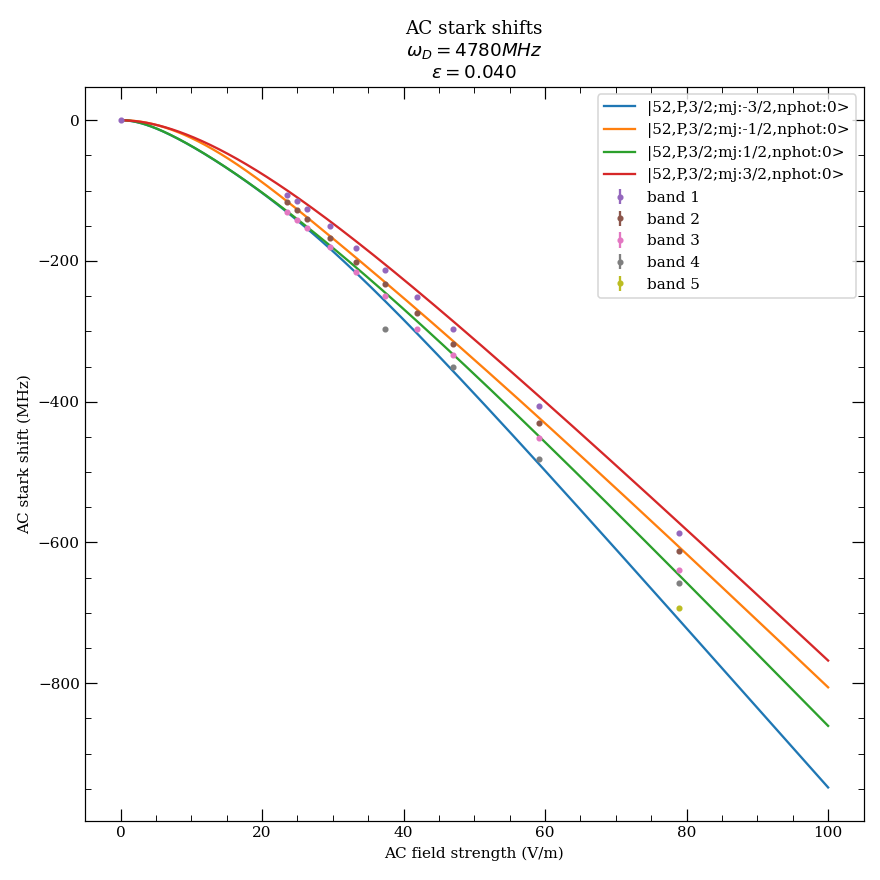

In [9]:
eps = np.arange(0,0.045,0.005)
for ellip in eps:
    ellip = float(ellip)
    fields = {
        "Eac": np.append(np.linspace(0,22,200), np.linspace(22+22/200,100,200)),
        "ellipticity": ellip,
        "field_omega": tau*4780e6,
        "Edc": 0.0,
        "theta": 0
    }

    for key, value in fields.items():
        try:
            tmp = value[1]
        except TypeError:
            continue
        else:
            varied = (key, value)

    H0 = build_H0(basis, t_level, offset_zeeman=1e6)
    energies, eigenstates = floquet_loop(basis, H0, n_max=n_max, varied=varied, **fields)

    thrs = 0.5
    fig, ax = plt.subplots(1,1, figsize=(8,8))

    basis_t = [i+len(basis)*n_max for i, state in enumerate(basis) if [state.n, state.l, state.j] == [t_level.n, t_level.l, t_level.j]]
    interesting_inds = []
    for t_ind in basis_t:
        for k, ps in enumerate(eigenstates[:, t_ind, :]):
            if max(np.absolute(ps)**2) > thrs:
                interesting_inds.append(k)

    interesting_inds = list(set(interesting_inds))
    for k in interesting_inds:
        ax.plot(varied[1], 1e-6*np.real(energies[k,:]-energies[k,0])/tau, label = basis_n[k].ket())

    scale = 79/0.474
    for band in bands:
        measured_res = res_df[y_str.format(band)]
        errb = res_df[er_str.format(band)]
        dAC = 2*(measured_res-bare_res)
        dAC_er = 2*errb
        x_data_scaled = x_data_Vs*scale
        ax.errorbar(x_data_scaled, dAC, yerr = dAC_er, fmt = ".", label=f"band {band}")

    ax.set_title(f"AC stark shifts\n$\omega_D = {fields['field_omega']*1e-6/tau:.0f} MHz$\n$\epsilon = {fields['ellipticity']:.3f}$")
    ax.set_ylabel("AC stark shift (MHz)")
    ax.set_xlabel("AC field strength (V/m)")
    ax.legend()
    fig.tight_layout()
    fig.show()
    fig.savefig(f"Theory-Experiment_handscale_ellipticity_{fields['ellipticity']:.3f}.png")

In [109]:
key

'ellipticity'

In [112]:
type(value)

numpy.float64

In [63]:
basis_t

[4, 5, 6, 7]

In [66]:
basis[basis_t[3]].ket()

'|52,P,3/2;mj:3/2>'